# SuperNEMO Summer Project
*author: Casimir Fisch*

- Analysis for ROOT files containing the RED data of a run in the Demonstator Module

- Focus on the cathode plasma propagation in the Geiger cells of the tracker chambers

In [101]:
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import ROOT
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path

plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'Open Sans'

In [26]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [29]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, PathPatch
from matplotlib.text import TextPath
from matplotlib.transforms import Affine2D
import mpl_toolkits.mplot3d.art3d as art3d

In [5]:
import matplotlib.cm as cm

In [6]:
from itertools import compress

In [17]:
from mpl_toolkits.mplot3d import Axes3D

In [7]:
# choose run number 
# (local ROOT file must be in the 'ROOT files' directory)

run_number = 732

# constants

tdc2sec = 12.5e-9
c_tdc2sec = 0.625E-08
tracker_height = 3.
cell_radius = 0.022 # order of magnitude
cell_diameter = 2*cell_radius
cell_err = cell_radius

# directories to which data / plots will be stored to

filedir = f'{run_number}/Files/'
plotsdir = f'{run_number}/Plots/'
tptdir = f'{run_number}/TPT/'
residdir = f'{run_number}/Residuals/'
level1_tracks_file = filedir+'tracks_firstlevel_max20_min8_minpos6.txt'
level2_tracks_file = filedir+'tracks_secondlevel_cutoff_0.05.txt'
onerow_tracks_file = filedir+'tracks_onerow.txt'
mean_tpts_file = filedir+'mean_tpts.txt'
mean_tpts_goodtracks_file = filedir+'mean_tpts_goodtracks.txt'

input_root_file = f'snemo_run-{run_number}_red.root'
file = ROOT.TFile(f'{input_root_file}', 'READ')
tree = file.RED

Find the lowest and highest rows + gives total number of events

used for the plotting functions later - if known already values can be entered manually (takes 10ish seconds for most runs)

In [8]:
def find_minmax_row():

    tree.GetEntry(0)
    rows = list(tree.tracker_cell_row_id)
    min_row, max_row = min(rows), max(rows)

    for event in tree:

        # layers = list(event.tracker_cell_layer_id) 
        rows = list(event.tracker_cell_row_id)
        # sides = list(event.tracker_cell_side_id)

        for r in rows:
            if r < min_row: min_row = r
            elif r > max_row: max_row = r

    print(f'min and max rows: {min_row} - {max_row}')
    return min_row, max_row

n_events = tree.GetEntries()
print(f'Total number of events: {n_events}')

min_row, max_row = find_minmax_row()

Total number of events: 61651
min and max rows: 0 - 37


# Filtering and plotting

To use the data, run filter level 1 and filter level 2 from the cell below successively. 

- **Level 1** filters tracks to ensure they have hits between a maximum and minimum value  
and feature a mimimum of 6 'good hits' (all cathode and anode times are positive)

- **Level 2** applies additional filtering to the tracks selected by level 1 by applying a cut-off  
for the residuals of a vertical linear fit. This ensures that the tracks passing the filter  
correspond to valid electron tracks, by dismissing events featuring outlier hits or complex topologies (eg more than one track)

In [51]:
def filter_level1(max_hits=20, min_hits=8, min_positive=6):

    # perform first-level filtering to the events in the ntuple file
    # and save the filtered tracks to a file, writing a track as [event_number side]

    filename = filedir + f'tracks_firstlevel_max{max_hits}_min{min_hits}_minpos{min_positive}.txt'
    f = open(filename, 'w')

    counter = 0

    for event in tree:

        event_number = event.event_id

        layers = list(event.tracker_cell_layer_id)
        rows = list(event.tracker_cell_row_id)
        sides = list(event.tracker_cell_side_id)

        hits_fr, hits_it = 0, 0
        good_hits_fr, good_hits_it = 0, 0 # ensures the variables are referenced

        for i in range(len(layers)):
            if sides[i] == 1:
                hits_fr += 1
            else: 
                hits_it += 1

        r5 = list(event.tracker_bottom_cathode_R5_ticks)[::10]
        r6 = list(event.tracker_top_cathode_R6_ticks)[::10]
        r0 = list(event.tracker_anode_R0_ticks)[::10]

        for i in range(len(r0)):
            an_time = r0[i] * tdc2sec
            bot_time, top_time = r5[i]*tdc2sec - an_time, r6[i]*tdc2sec - an_time

            if sides[i] == 1: # france

                if max_hits >= hits_fr >= min_hits:
                    # good_hits_fr = 0
                    if an_time > 0 and bot_time > 0 and top_time > 0:
                        good_hits_fr += 1

            else: # italy

                if max_hits >= hits_it >= min_hits:
                    # good_hits_it = 0
                    if an_time > 0 and bot_time > 0 and top_time > 0:
                        good_hits_it += 1

        if good_hits_fr >= min_positive:
            # print(event_number, 'france')
            f.write('{} {}\n'.format(event_number, 1))
            counter+=1
        
        if good_hits_it >= min_positive:
            # print(event_number, 'italy')
            f.write('{} {}\n'.format(event_number, 0))
            counter+=1

    f.close()
    print('\ntotal tracks (filter 1): ', counter)

def filter_level2(resid_cutoff=0.05):

    filename = level1_tracks_file
    data = np.loadtxt(filename, dtype = int)
    e_nums, sides = data[:,0], data[:,1]

    newfile = filedir + f'tracks_secondlevel_cutoff_{resid_cutoff}.txt'
    f = open(newfile, 'w')
    counter = 0

    # run through the good tracks and introduce a filter that gets rid of instances where the error on the fit
    # is above a certain cutoff value (0.05 by inspection of tracks).

    for i in range(len(e_nums)):

        event_number = e_nums[i]
        tree.GetEntry(event_number)

        n, l, r, top, bot = filter_track(event_number, sides[i])
        # fit_err = get_fit_error(l, top, bot)
        residuals = get_residuals(l, top, bot)

        no_bad_resids = True
        for resid in residuals:
            if abs(resid) > resid_cutoff: 
                no_bad_resids = False
                break 

        if no_bad_resids == False: continue 
  
        # print(event_number, sides[i])
        f.write('{} {}\n'.format(e_nums[i], sides[i]))
        counter+=1

    f.close()

    print('total tracks without cutoff:', len(e_nums))
    print('total tracks with cutoff   :', counter)

def filter_onerow():

    filename = level2_tracks_file
    data = np.loadtxt(filename, dtype = int)
    e_nums, sides = data[:,0], data[:,1]
    counter = 0

    newfile = open(onerow_tracks_file, 'w')

    for i in range(len(e_nums)):

        event_number = e_nums[i]
        tree.GetEntry(event_number)

        cell_nums, layers, rows, top, bot = filter_track(event_number, sides[i])
        count_samerow = 0

        for row in rows:
            if row == rows[0]: count_samerow += 1
        
        if count_samerow == len(rows): # all rows are the same
            counter += 1
            newfile.write(f'{event_number} {sides[i]}\n')

    newfile.close()
    print(f'{counter} one-row tracks')

def find_bb_decays(margin=0.1):

    filename = level2_tracks_file
    data = np.loadtxt(filename, dtype=str)
    e_nums, sides = data[:,0].astype(int), data[:,1].astype(int)

    # starting point within 10cm on either side of foil

    bb_decay_tracks_file = f'tracks_bb_decays_margin{margin}.txt'
    f = open(bb_decay_tracks_file, 'w')
    prev_event_number = 0
    counter = 0

    for i in range(len(e_nums)):

        event_number = e_nums[i]

        if event_number == prev_event_number: # two good tracks with same event number

            # # if there are events
            # if np.sum(layers[france]==0) >= 1 and np.sum(layers[italy]==0) >= 1:

            #     # if the starting row of the two tracks are the same, count it as a bb decay.
            #     same_row_arr = np.intersect1d(rows[france][layers[france]==0], rows[italy][layers[italy]==0])
            #     if same_row_arr.size != 0:
 
            n_fr, l_fr, r_fr, top_fr, bot_fr = filter_track(event_number, 1) # france
            n_it, l_it, r_it, top_it, bot_it = filter_track(event_number, 0) # italy

            vert_dist_fr = vertical_dist(top_fr, bot_fr)
            horz_dist_fr = layers_to_distances(l_fr)
            vert_dist_it = vertical_dist(top_it, bot_it)
            horz_dist_it = layers_to_distances(l_it)
            popt_fr, _ = curve_fit(linear, horz_dist_fr, vert_dist_fr)
            popt_it, _ = curve_fit(linear, horz_dist_it, vert_dist_it)

            track_atfoil_fr = popt_fr[1]
            track_atfoil_it = popt_it[1]

            print('france: {:.2f} m, italy {:.2f} m'.format(track_atfoil_fr, track_atfoil_it))
            
            # if the reconstructed tracks on either side of the source foil land with {margin} of each other
            if abs(track_atfoil_fr - track_atfoil_it) < margin:

                counter+=1
                # print(event_number, 'bb decay!')
                f.write(f'{event_number} france\n{event_number} italy\n'.format(event_number))

        prev_event_number = event_number

    f.close()
    print('\ntotal number of events:', counter)

def tracks_passing_filters():

    f1 = open(level1_tracks_file, 'r')
    # level1_n_tracks = len(f1.readlines())
    data = np.loadtxt(f1)
    lvl1_n_events = np.unique(data[:,0]).size
    f2 = open(level2_tracks_file, 'r')
    # level2_n_tracks = len(f2.readlines())
    data = np.loadtxt(f2)
    lvl2_n_events = np.unique(data[:,0]).size
    f1.close(); f2.close()
    fraction1 = lvl1_n_events / n_events *100
    fraction2 = lvl2_n_events / n_events *100

    print(f'run {run_number}')
    print('{} total events\n{} events from level 1 ({:.2f} %)\n{} events from level 2 ({:.2f} %)'.format(n_events, lvl1_n_events, fraction1, lvl2_n_events, fraction2))

def write_residuals_to_file(param = 'lvl2'):

    # create mega list of all residuals across all events
    # then write them to individual files for each cell

    if param == 'onerow': filename = onerow_tracks_file
    else: filename = level2_tracks_file

    data = np.loadtxt(filename, dtype=int)
    e_nums, sides = data[:,0], data[:,1]

    all_cell_nums = get_all_cell_nums()
    resid_mega_list = [[] for i in range(len(all_cell_nums))]

    for i in range(len(e_nums)):

        event_number, side = e_nums[i], sides[i]

        cell_nums, layers, rows, top_times, bot_times = filter_track(event_number, side)
        residuals = get_residuals(layers, top_times, bot_times)

        for j in range(len(cell_nums)):

            ind = all_cell_nums.index(cell_nums[j])
            resid_mega_list[ind].append(residuals[j])

    # write the mega list to files
    # also write the standard deviation of the residuals of one cell to a separate file
    # this is the vertical error used in plotting

    if param == 'onerow':
        newfile = filedir + 'resids_onerow.txt'
    else: newfile = filedir + 'vertical_errors.txt'

    f = open(newfile, 'w')

    for z in range(len(all_cell_nums)):

        cell_num = all_cell_nums[z]
        resid_list = resid_mega_list[z]

        if param == 'onerow': resid_file = residdir + f'residuals_onerow_cell_{cell_num}.txt'
        else: resid_file = residdir + f'residuals_cell_{cell_num}.txt'

        if len(resid_list) != 0:
            np.savetxt(resid_file, resid_list)

        if len(resid_list) == 0:
            f.write('{} nan\n'.format(cell_num))

        elif len(resid_list) == 1:
            # potential malfunctioning cells, the error is the only available residual
            f.write('{} {:.6f}\n'.format(cell_num, resid_list[0]))

        else:
            # if still malfunctioning but at least 2 residuals, stdev is a good enough approx
            resid_stdev = np.std(resid_list)
            f.write('{} {:.6f}\n'.format(cell_num, resid_stdev))

    f.close()

def filter_event(event_number):

    tree.GetEntry(event_number)

    layers = list(tree.tracker_cell_layer_id) 
    rows = list(tree.tracker_cell_row_id)
    sides = list(tree.tracker_cell_side_id)
    r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
    r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
    r0 = list(tree.tracker_anode_R0_ticks)[::10]
    calo_ticks = list(tree.calo_ticks)                                 # list(int) Calo TDC (6.25ns)
    calo_ht = list(tree.calo_ht)
    calo_times=np.array(list(np.compress(calo_ticks, calo_ht)))
    #calo time

    bot_times, top_times, anode_times, l, r, s = [], [], [], [], [], [] ###
    for i in range(len(r0)):
        an_time = r0[i]*tdc2sec
        bot_time = r5[i]*tdc2sec - an_time
        top_time = r6[i]*tdc2sec - an_time
        anode_time = np.array(r0)*tdc2sec - calo_times[0]*c_tdc2sec ###

        if bot_time > 0 and top_time > 0 and an_time > 0:
            bot_times.append(bot_time*1e6)
            top_times.append(top_time*1e6)
            anode_times.append(anode_time) ###
            l.append(layers[i]); r.append(rows[i]); s.append(sides[i])
    
    cell_nums = LRS_to_num(l, r, s)

    return cell_nums, l, r, s, top_times, bot_times, anode_times

def filter_track(event_number, side):

    cell_nums, layers, rows, sides, top_times, bot_times, anode_times = filter_event(event_number)
    n, l, r, t, b, a = [], [], [], [], [], []
    for i in range(len(layers)):

        if sides[i] == side:
            n.append(cell_nums[i]); l.append(layers[i]); r.append(rows[i]); b.append(bot_times[i]); t.append(top_times[i]); a.append(anode_times[i])

    return n, l, r, t, b, a

def scan_track(event_number, side):

    side_str = 'france' if side == 1 else 'italy'
    cell_nums, layers, rows, top_times, bot_times, anode_times = filter_track(event_number, side)
    
    sorted_inds = np.argsort(layers)
    cells, l, r = np.array(cell_nums)[sorted_inds], np.array(layers)[sorted_inds], np.array(rows)[sorted_inds]
    top, bot = np.array(top_times)[sorted_inds], np.array(bot_times)[sorted_inds]
    vert_sorted = vertical_fractional(top, bot)
    horz_sorted = layers_to_distances(l)
    vert_errors = vertical_errors(cells)

    print('\n*** Event {0} ({1}) ***'.format(event_number, side_str))
    for i in range(len(l)):
        print('''cell {} / layer {} / row {} / top {:.3f} / bot {:.3f} / vertical dist {:.3f} +/- {:.3f}'''.format(cells[i], l[i], r[i], top[i], bot[i], vert_sorted[i], vert_errors[i]))

    plot_vertical(vert_sorted, horz_sorted, vert_errors, event_number, side)

def plot_xy_event(event_number):

    n_rows, n_layers = (max_row - min_row + 1), 18
    grid = np.zeros((n_rows, n_layers))

    tree.GetEntry(event_number)

    layers = list(tree.tracker_cell_layer_id) 
    rows = list(tree.tracker_cell_row_id)
    sides = list(tree.tracker_cell_side_id)
    r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
    r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
    r0 = list(tree.tracker_anode_R0_ticks)[::10]
    calo_ticks = list(tree.calo_ticks)                                 # list(int) Calo TDC (6.25ns)
    calo_ht = list(tree.calo_ht)
    calo_times=np.array(list(compress(calo_ticks, calo_ht)))
    

    layers = adjusted_layers(layers, sides)
    layers, rows, sides = np.array(layers), np.array(rows), np.array(sides)
    an_times = np.array(r0)*tdc2sec
    bot_times = np.array(r5)*tdc2sec - an_times
    top_times = np.array(r6)*tdc2sec - an_times
    print(len(calo_ticks),calo_times)
    
    #for now, just select first cathode time but later on select it in fNCY ways
    anode_time = np.array(r0)*tdc2sec - calo_times[0]*c_tdc2sec

    no_cathode_filter = (an_times > 0) * (top_times < 0) * (bot_times < 0)
    top_cathode_filter = (an_times > 0) * (top_times > 0) * (bot_times < 0)
    bot_cathode_filter = (an_times > 0) * (top_times < 0) * (bot_times > 0)
    both_cathodes_filter = (an_times > 0) * (top_times > 0) * (bot_times > 0)
    neg_anode_filter = (anode_time < 0)

    fig, ax = plt.subplots(figsize=(8,10), tight_layout=True)
    ax.set_aspect(1)

    major_xticks = np.arange(min_row,max_row+1)
    minor_xticks = np.arange(min_row-.5,max_row+1.5)
    major_yticks = np.arange(-8.5,9.5)
    minor_yticks = np.arange(-9,10)
    layer_ticks = [8,7,6,5,4,3,2,1,0,0,1,2,3,4,5,6,7,8]

    both_cathodes_label = 'both cathodes'
    top_cathode_label = 'top cathode only'
    bot_cathode_label = 'bottom cathode only'
    no_cathode_label = 'no cathodes'
    neg_anode_label = 'anode time is negative'
    ax.scatter(rows[both_cathodes_filter], layers[both_cathodes_filter], s=100, marker='o', color='g', alpha=0.5, label=both_cathodes_label)
    ax.scatter(rows[top_cathode_filter], layers[top_cathode_filter], s=100, marker='o', color='orange', alpha=0.5, label=top_cathode_label)
    ax.scatter(rows[bot_cathode_filter], layers[bot_cathode_filter], s=100, marker='o', color='b', alpha=0.5, label=bot_cathode_label)
    ax.scatter(rows[no_cathode_filter], layers[no_cathode_filter], s=100, marker='o', color='r', alpha=0.5, label=no_cathode_label)
    ax.scatter(rows[neg_anode_filter], layers[neg_anode_filter], s=100, marker='o', color='c', alpha=0.5, label=neg_anode_label)
    print(anode_time)
    rs = []
    for i, txt in enumerate(anode_time):
        ax.annotate('t: {0:.2f}'.format(float(txt)/1e-6), (rows[i]+1, layers[i]))

        if anode_time[i] > 0:
            r = invertfunc(anode_time[i],a,b)
            rs.append(r)
            ax.annotate('r: {0:.2f}'.format(float(r)), (rows[i]+4, layers[i]))
        if anode_time[i] < 0:
            rs.append(0)
    print(rs)

        #ax.annotate(txt, (rows[i], layers[i]))
   # for i in rows:
   #     for j in layers:
            
    #ax.annotate

    ax.plot(np.arange(min_row-1,max_row+2), np.zeros_like(np.arange(min_row-1,max_row+2)), 'k', linewidth=2) # source foil line
    ax.set_xlim(min_row-.5,max_row+.5)
    ax.set_ylim(-9,9)
    ax.set_xticks(major_xticks)
    ax.set_yticks(major_yticks)
    ax.set_xticks(minor_xticks, minor = True)
    ax.set_yticks(minor_yticks, minor = True)
    ax.set_yticklabels(layer_ticks)
    ax.set_ylabel('layer')
    ax.set_xlabel('row')
    ax.grid(which='minor')
    ax.set_title(f'Event {event_number} - run {run_number}')
    # ax.text(0.5, 0.75, 'France', transform=ax.transAxes, fontsize='xx-large', horizontalalignment='center', verticalalignment='center', fontfamily='serif', fontweight='bold')
    # ax.text(0.5, 0.25, 'Italy', transform=ax.transAxes, fontsize='xx-large', horizontalalignment='center', verticalalignment='center', fontfamily='serif', fontweight='bold')
    ax.text(-.04, 0.75, 'FRANCE', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.text(-.04, 0.25, 'ITALY', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    
    ax.legend(loc='upper left')

    # fig.savefig(osdir+f'xyplane_event{event_number}.png')

    plt.show()

def plot_3D_event(event_number, scatter=True):

    #fig = plt.figure(figsize=plt.figaspect(4)*3) #(10,8)
    
    w, h = plt.figaspect(2.)*3
    fig = plt.figure(figsize=(w, h))
    
    ax = fig.add_subplot(projection='3d')

    xs = np.arange(min_row-.5, max_row+1.5, 0.1)
    zs = np.arange(0, tracker_height+0.1, 0.1)
    X, Z = np.meshgrid(xs, zs)
    Y = np.zeros_like(X)
    ax.plot_surface(X, Y, Z, alpha=0.3, color='k', linewidth=10)

    major_xticks = np.arange(min_row, max_row+1, 5)
    minor_xticks = np.arange(min_row-.5, max_row+1.5)
    major_yticks = np.arange(-8.5,9.5)
    minor_yticks = np.arange(-9,10)
    layer_ticks = [8,7,6,5,4,3,2,1,0,0,1,2,3,4,5,6,7,8]

    ax.set_xlim(min_row-.5, max_row+1.5)
    ax.set_ylim(-8.5,8.5)
    ax.set_xticks(major_xticks)
    ax.set_yticks(major_yticks)
    # ax.set_xticks(minor_xticks, minor = True)
    # ax.set_yticks(minor_yticks, minor = True)
    ax.set_yticklabels(layer_ticks)
    ax.xaxis.grid(which='minor')
    ax.yaxis.grid(which='minor')

    text_rowpos = (min_row+max_row)/2
    ax.text(text_rowpos, -4, 0.1*tracker_height, 'Italy',  fontsize='large', horizontalalignment='center', verticalalignment='center', fontfamily='serif')
    ax.text(text_rowpos, +4, 0.1*tracker_height, 'France', fontsize='large', horizontalalignment='center', verticalalignment='center', fontfamily='serif')

    ax.set_zlim(0, tracker_height)
    ax.set_xlabel('Row number')
    ax.set_ylabel('Layer number')
    ax.set_zlabel('Vertical distance')
    # title = f'3D plot of event {event_number}'

    _, l, r, s, top, bot, an = filter_event(event_number)
    vert_dist = vertical_dist(top, bot)
    l = adjusted_layers(l, s)

    if scatter == True:
        ax.scatter(r, l, vert_dist, color='r')
    else:
        ax.plot(r, l, vert_dist)

    ax.view_init(15,-8)
   # ax.set_box_aspect(aspect = (3,1,1))
    ax.set_aspect('auto')
    # ax.set_title(title)
    fig.savefig('3D_2sides_event{}.png'.format(event_number))
    plt.show()

def adjusted_layers(l, s):

    adjusted_layers = []

    for i in range(len(l)):
        if s[i] == 1:
            adjusted_layer =  l[i] + .5
            adjusted_layers.append(adjusted_layer)
        else:
            adjusted_layer = -l[i] - .5
            adjusted_layers.append(adjusted_layer)

    return adjusted_layers #np.array(adjusted_layers)

def num_to_LRS(cell_nums):

    layers, rows, sides = [], [], []

    for cell_num in cell_nums:
        sides.append(cell_num // (9 * 113))
        rows.append(cell_num % (9 * 113) // 9)
        layers.append(cell_num % (9 * 113) % 9)
    
    return layers, rows, sides

def LRS_to_num(layers, rows, sides):

    nums = []
    for i in range(len(layers)):
        nums.append(sides[i]*113*9 + rows[i]*9 + layers[i])
    return nums

def calc_cell_num(l, r, s):
    return s*113*9 + r*9 + l

def vertical_fractional(top_dts:np.array, bot_dts:np.array):

    total_dts = top_dts + bot_dts
    return bot_dts/total_dts * tracker_height

def vertical_dist(top_times, bot_times):

    bot_distances = []
    for i in range(len(top_times)):
        tpt = top_times[i] + bot_times[i]
        bot_distances.append(bot_times[i] / tpt * tracker_height)
    return bot_distances

def vertical_errors(cells_list):

    data = np.loadtxt(filedir+'vertical_errors.txt', dtype=float)
    cell_nums, vert_errs = data[:,0].astype(int), data[:,1]

    errors = []

    for cell in cells_list:
        error_bar = vert_errs[cell_nums==cell][0] / 2
        errors.append(error_bar)
    
    return errors

def layers_to_distances(layers):

    horz_dists = []
    for i in range(len(layers)):
        horz_dists.append((layers[i] + .5) * cell_diameter)
    return horz_dists

def plot_vertical(vert_dist, horz_dist, vert_err, event_number, side, interpolate=False, invert=False):

    side_str = 'france' if side == 1 else 'italy'

    # t_dist and b_dist are mirror images of each other because they are calculated as fractions
    # only consider one of them (bottom, since the electron goes up when the bottom fraction increases)
    popt, pcov = curve_fit(linear, horz_dist, vert_dist) # sigma=vert_err
    perr = np.sqrt(np.diag(pcov))

    line_xs = np.arange(0,10)*cell_diameter
    cell_boundaries = np.arange(0.5,8.5)*cell_diameter + cell_radius

    fig, ax = plt.subplots(tight_layout=True, figsize=(5,6))

    # title = 'Vertical (fractional) trajectory against horizontal distance\nfor track [{} - {}]'.format(event_number, side)
    ax.errorbar(horz_dist, vert_dist, yerr=vert_err, xerr=cell_err, fmt='o', color='k') #355C7D #
    ax.plot(line_xs, linear(line_xs, *popt), '-', color='r') #F67280
    ax.set_title('Run {} - Event {}, {}'.format(run_number, event_number, side_str.capitalize()))
    # fig.suptitle(title)
    ax.set_xlabel('layer axis /m') #'distance from source foil /m', fontsize='large'
    ax.set_ylabel('z /m', rotation='horizontal') #fontsize='large'
    ax.yaxis.set_label_coords(-0.05,1.)
    ax.set_xlim(line_xs[0], line_xs[-1])
    if invert:
        ax.invert_xaxis()

    for boundary in cell_boundaries:
        ax.axvline(boundary, color='k', linestyle='dashed', alpha=0.5, linewidth=1)

    # ax.text(0.05, 0.05, 'error of fit: {:.4e}'.format(perr[0]), transform=ax.transAxes)

    # if tpt_err==True:
    #     fig.savefig(osdir+vertical_dir+'track{0}_{1}_tpterr.png'.format(event_number, side))
    # elif interpolate==True:
    #     fig.savefig(osdir+vertical_dir+'track{0}_{1}_interpolated.png'.format(event_number, side))
    # else:
    #     fig.savefig(osdir+vertical_dir+'track{0}_{1}.png'.format(event_number, side))

    plt.show()

def get_all_cell_nums():

    rows = np.arange(min_row,max_row+1)
    layers = np.arange(0,9)
    sides = np.array([0,1])

    all_cell_nums = []

    for side in sides:
        for layer in layers:
            for row in rows:
                all_cell_nums.append(side*113*9 + row*9 + layer)

    return all_cell_nums

def linear(x, m, p):
    return m*x+p 
    
def get_residuals(layers, top, bot):

    vert_dist = vertical_dist(top, bot)
    horz_dist = layers_to_distances(layers)

    popt, _ = curve_fit(linear, horz_dist, vert_dist)
    resids = []
    for i in range(len(vert_dist)):
        resids.append(vert_dist[i] - linear(horz_dist[i], *popt))
    return resids

## Reconstructing radii

In [52]:
def invertfunc(t,a,b):
    
    """ A function that calculates distance from time"""
    power = (1/(1-b))
    
    return (t/a)**power

In [53]:
#for ctl880 data
a,b = [8.56128044e-07, -9.14129862e-01] #r<2.2
a2,b2 = [3.96575107e-07, -1.98864081e+00] #r>2.2

In [54]:
def filter_event(event_number):

    tree.GetEntry(event_number)

    layers = list(tree.tracker_cell_layer_id) 
    rows = list(tree.tracker_cell_row_id)
    sides = list(tree.tracker_cell_side_id)
    r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
    r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
    r0 = list(tree.tracker_anode_R0_ticks)[::10]
    calo_ticks = list(tree.calo_ticks)                                 # list(int) Calo TDC (6.25ns)
    calo_ht = list(tree.calo_ht)
    calo_times=np.array(list(np.compress(calo_ticks, calo_ht)))
    #calo time
        
    anode_time = np.array(r0)*tdc2sec - calo_times[0]*c_tdc2sec ###


    bot_times, top_times, anode_times, l, r, s = [], [], [], [], [], [] ###
    for i in range(len(r0)):
        an_time = anode_time[i] #r0[i]*tdc2sec
        bot_time = r5[i]*tdc2sec - an_time
        top_time = r6[i]*tdc2sec - an_time
    

        if bot_time > 0 and top_time > 0 and an_time > 0:
            bot_times.append(bot_time*1e6)
            top_times.append(top_time*1e6)
            anode_times.append(an_time) ###
            l.append(layers[i]); r.append(rows[i]); s.append(sides[i])
    
    cell_nums = LRS_to_num(l, r, s)
    

    
    return cell_nums, l, r, s, top_times, bot_times, anode_times


6 [3402211918 3402211917 3402212731]
[ 3.65000000e-06  7.87499999e-07  7.87499999e-07  1.81250000e-06
  1.99999999e-07  1.40000000e-06 -1.00000001e-07  1.62500000e-06
 -1.00000001e-07  6.47500000e-06  7.12500000e-07  4.99999999e-07
  1.28750000e-06  8.25000001e-07  1.12500000e-07  2.49999985e-08
  2.38750000e-06  3.33750000e-06  2.95000000e-06]
[2.1330588115036497, 0.9572865441127373, 0.9572865441127373, 1.4797085099253195, 0.4678218684492582, 1.2929614932243025, 0, 1.3976553250706525, 0, 2.8777980288538068, 0.9085192766610031, 0.7550514656083797, 1.2375967180881096, 0.9808369580526937, 0.34636730041689895, 0.15786238834962513, 1.7088070193103264, 2.0356125602222983, 1.9085046806218935]


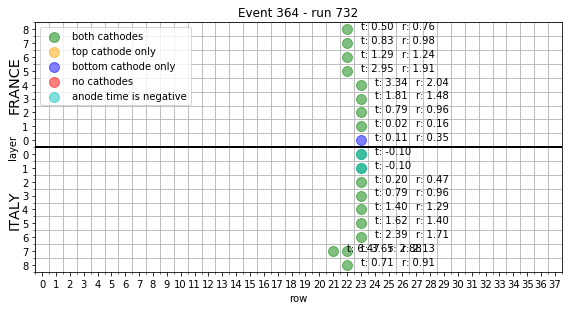

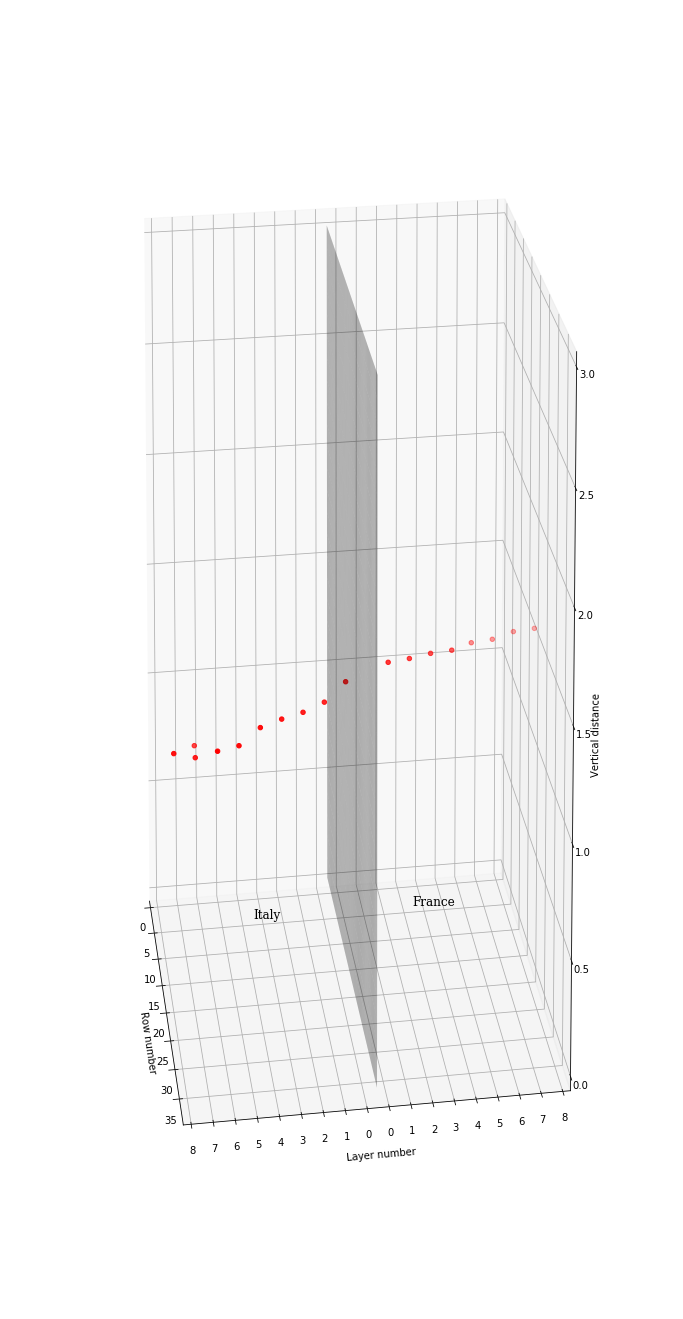

In [55]:
e_num = 364

# scan_track(e_num, 1)
plot_xy_event(e_num)
plot_3D_event(e_num) #also need to adjust code for calo data

In [56]:
### 3d plots with radius - betsy
def plot_3D_event_rad(event_number):
    
    ################################################ new code ##################################################################
    n_rows, n_layers = (max_row - min_row + 1), 18
    grid = np.zeros((n_rows, n_layers))

    tree.GetEntry(event_number)

    layers = list(tree.tracker_cell_layer_id) 
    rows = list(tree.tracker_cell_row_id)
    sides = list(tree.tracker_cell_side_id)
    r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
    r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
    r0 = list(tree.tracker_anode_R0_ticks)[::10]
    calo_ticks = list(tree.calo_ticks)                                 # list(int) Calo TDC (6.25ns)
    calo_ht = list(tree.calo_ht)
    calo_times=np.array(list(compress(calo_ticks, calo_ht)))
    
    layers = adjusted_layers(layers, sides)
    layers, rows, sides = np.array(layers), np.array(rows), np.array(sides)
    an_times = np.array(r0)*tdc2sec
    bot_times = np.array(r5)*tdc2sec - an_times
    top_times = np.array(r6)*tdc2sec - an_times
    #print(len(calo_ticks),calo_times)
    
    #for now, just select first cathode time but later on select it in fNCY ways
    anode_time = np.array(r0)*tdc2sec - calo_times[0]*c_tdc2sec
    
    #print(len(anode_time))
    rs = []
    for i, txt in enumerate(anode_time):
        #ax.annotate('t: {0:.2f}'.format(float(txt)/1e-6), (rows[i]+1, layers[i]))

        if anode_time[i] > 0 and anode_time[i] < 4e-6:
            r = invertfunc(anode_time[i],a,b)
            rs.append(r)
        if anode_time[i] > 4e-6:
            r = invertfunc(anode_time[i],a2,b2)
            rs.append(r)
            #ax.annotate('r: {0:.2f}'.format(float(r)), (rows[i]+4, layers[i]))
        if anode_time[i] < 0:
            rs.append(0)
    #print(rs)
#############################################################################################################################

    
    w, h = plt.figaspect(1.5)*3
    fig = plt.figure(figsize=(w, h))
    
    ax = fig.add_subplot(projection='3d')

    xs = np.arange(min_row-.5, max_row+1.5, 0.1)
    zs = np.arange(0, tracker_height+0.1, 0.1)
    X, Z = np.meshgrid(xs, zs)
    Y = np.zeros_like(X)
    ax.plot_surface(X, Y, Z, alpha=0.3, color='k', linewidth=10)

    major_xticks = np.arange(min_row, max_row+1, 5)
    minor_xticks = np.arange(min_row-.5, max_row+1.5)
    major_yticks = np.arange(-8.5,9.5)#*4#2.2
    minor_yticks = np.arange(-9,10)#*4#2.2
    
    layer_ticks = [8,7,6,5,4,3,2,1,0,0,1,2,3,4,5,6,7,8]#*4#2.2

    ax.set_xlim(min_row-.5, max_row+1.5)
    ax.set_ylim(-8.5,8.5)#*4#2.2
    ax.set_xticks(major_xticks)
    ax.set_yticks(major_yticks)
    ax.set_yticklabels(layer_ticks)
    ax.xaxis.grid(which='minor')
    ax.yaxis.grid(which='minor')

    text_rowpos = (min_row+max_row)/2
    ax.text(text_rowpos, -4, 0.1*tracker_height, 'Italy',  fontsize='large', horizontalalignment='center', verticalalignment='center', fontfamily='serif')
    ax.text(text_rowpos, +4, 0.1*tracker_height, 'France', fontsize='large', horizontalalignment='center', verticalalignment='center', fontfamily='serif')

    ax.set_zlim(0, tracker_height)
    ax.set_xlabel('Row number')
    ax.set_ylabel('Layer number')
    ax.set_zlabel('Vertical distance')

    _, l, r, s, top, bot, an = filter_event(event_number)
    vert_dist = vertical_dist(top, bot)
    l = adjusted_layers(l, s)
    
    #print(len(l),len(r),len(vert_dist),len(rs))
    
    c = np.array(rs)/4.4
    colors = [cm.jet(color) for color in c]
    
    for i in range(len(r)):
        p = Circle((r[i], l[i]), rs[i]/4.4, fill=False, color=colors[i])#0.5)
        ax.add_patch(p)
        art3d.pathpatch_2d_to_3d(p, z=vert_dist[i], zdir="z")
        if anode_time[i]>4e-6:
            ax.scatter(r[i], l[i], vert_dist[i], color='lime', label='r>2.2 cm, t>4 us')
        if rs[i]==0:
            ax.scatter(r[i], l[i], vert_dist[i], color='r', label='no calo time')
            

    ax.view_init(15,-8)
    ax.set_aspect('auto')
    fig.savefig('3D_2sides_event{}.png'.format(event_number))
    u = ax.scatter(r, l, vert_dist, s=0, c=rs) ############ fix length of r
    plt.colorbar(u,fraction=0.032, pad=0.02)
    plt.legend()
    title = str('event number ') + str(event_number)
    plt.title(title)
    plt.show()


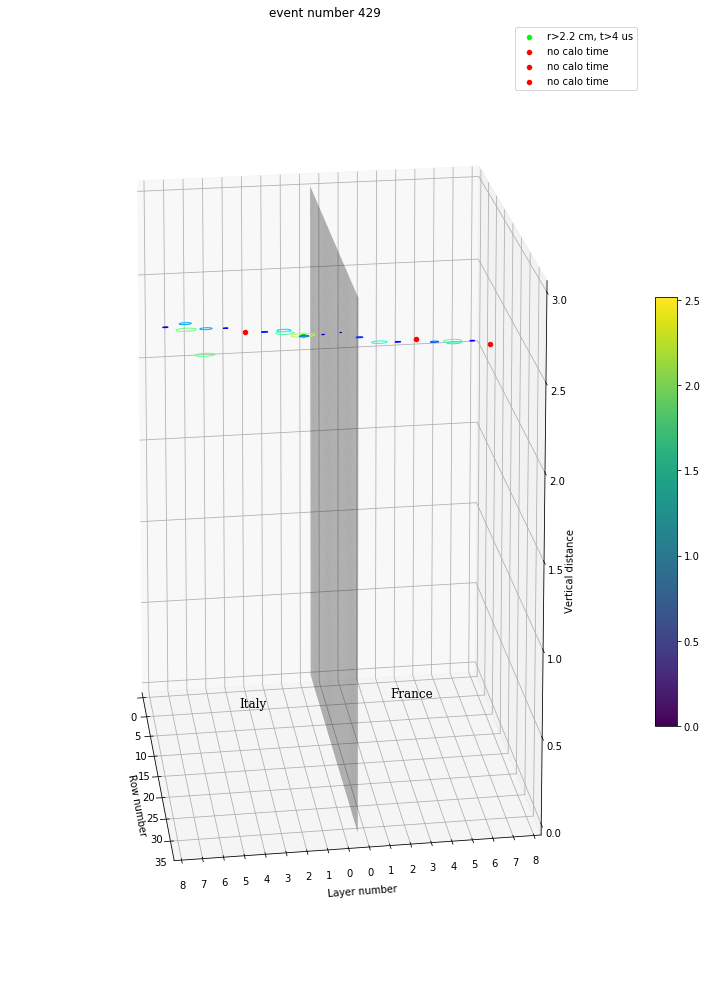

In [57]:
plot_3D_event_rad(429)

In [131]:
### 2d plots with radius - betsy

def plot_xy_event_rad(event_number):

    n_rows, n_layers = (max_row - min_row + 1), 18
    grid = np.zeros((n_rows, n_layers))

    tree.GetEntry(event_number)

    layers = list(tree.tracker_cell_layer_id) 
    rows = list(tree.tracker_cell_row_id)
    sides = list(tree.tracker_cell_side_id)
    r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
    r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
    r0 = list(tree.tracker_anode_R0_ticks)[::10]
    calo_ticks = list(tree.calo_ticks)                                 # list(int) Calo TDC (6.25ns)
    calo_ht = list(tree.calo_ht)
    calo_times=np.array(list(compress(calo_ticks, calo_ht)))
    

    layers = adjusted_layers(layers, sides)
    layers, rows, sides = np.array(layers), np.array(rows), np.array(sides)
    an_times = np.array(r0)*tdc2sec
    bot_times = np.array(r5)*tdc2sec - an_times
    top_times = np.array(r6)*tdc2sec - an_times
    
    
    #for now, just select first cathode time but later on select it in fNCY ways
    anode_time = np.array(r0)*tdc2sec - calo_times[0]*c_tdc2sec

    no_cathode_filter = (an_times > 0) * (top_times < 0) * (bot_times < 0)
    top_cathode_filter = (an_times > 0) * (top_times > 0) * (bot_times < 0)
    bot_cathode_filter = (an_times > 0) * (top_times < 0) * (bot_times > 0)
    both_cathodes_filter = (an_times > 0) * (top_times > 0) * (bot_times > 0)
    neg_anode_filter = (anode_time < 0)

    fig, ax = plt.subplots(figsize=(12,14), tight_layout=True)
    ax.set_aspect(1)

    major_xticks = np.arange(min_row,max_row+1)
    minor_xticks = np.arange(min_row-.5,max_row+1.5)
    major_yticks = np.arange(-8.5,9.5)
    minor_yticks = np.arange(-9,10)
    layer_ticks = [8,7,6,5,4,3,2,1,0,0,1,2,3,4,5,6,7,8]

    both_cathodes_label = 'both cathodes'
    top_cathode_label = 'top cathode only'
    bot_cathode_label = 'bottom cathode only'
    no_cathode_label = 'no cathodes'
    neg_anode_label = 'anode time is negative'
    
    #print(anode_time)
    rs = []
    for i, txt in enumerate(anode_time):
        ax.annotate('t: {0:.2f}'.format(float(txt)/1e-6), (rows[i]+1, layers[i]))

        if anode_time[i] > 0 and anode_time[i]<4e-6:
            r = invertfunc(anode_time[i],a,b)
            rs.append(r)
            ax.annotate('r: {0:.2f}'.format(float(r)), (rows[i]+4, layers[i]))
        if anode_time[i] > 4e-6:
            r = invertfunc(anode_time[i],a2,b2)
            rs.append(r)
            ax.annotate('r: {0:.2f}'.format(float(r)), (rows[i]+4, layers[i]), color='lime')
        if anode_time[i] < 0:
            rs.append(0)
            ax.annotate('r: NaN', (rows[i]+4, layers[i]), color='red')
    
    #this replaces r values that are higher than the maximum cell distance with value 0 
    newlist = [x if x <= np.sqrt(2*2.2**2) else 0 for x in rs]


    #cm1 = plt.cm.get_cmap('RdYlBu')
    
    #sc = ax.scatter(rows, layers, s=0, c=rs, cmap=cm1)
    #plt.colorbar(sc)
    
    c = np.array(rs)/4.4 #e-6
    colors = [cm.jet(color) for color in c]
    #colors = [cm.jet(rs)]
    
    u = ax.scatter(rows, layers, s=0, c=rs, cmap='cool')#colors)#, cmap=cm)#np.array(rs)/4.4)#colors)#rs) 
    
    colors2=u.to_rgba(rs)
    
    for i in range(len(rs)):
        if rs[i]>0:
            p = Circle((rows[i], layers[i]), rs[i]/4.4, fill=False, color=colors2[i])#colors[i])#0.5)
            ax.add_patch(p)
       
    ax.plot(np.arange(min_row-1,max_row+2), np.zeros_like(np.arange(min_row-1,max_row+2)), 'k', linewidth=2) # source foil line
    ax.set_xlim(min_row-.5,max_row+.5)
    ax.set_ylim(-9,9)
    ax.set_xticks(major_xticks)
    ax.set_yticks(major_yticks)
    ax.set_xticks(minor_xticks, minor = True)
    ax.set_yticks(minor_yticks, minor = True)
    ax.set_yticklabels(layer_ticks)
    ax.set_ylabel('layer')
    ax.set_xlabel('row')
    ax.grid(which='minor')
    ax.set_title(f'Event {event_number} - run {run_number}')
    
    ax.text(-.04, 0.75, 'FRANCE', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.text(-.04, 0.25, 'ITALY', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    
    #ax.legend(loc='upper left')

    plt.colorbar(u,fraction=0.022, pad=0.06)
    plt.show()

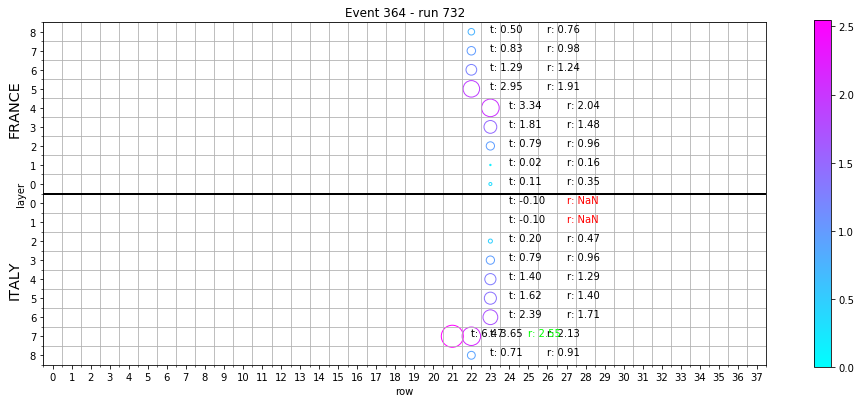

In [134]:
plot_xy_event_rad(364)

In [45]:
def get_good_events(event_number):
    
    """gets events where number of cathode hits equals number of anode hits so that a full track can be reconstructed"""
    
    n_rows, n_layers = (max_row - min_row + 1), 18
    grid = np.zeros((n_rows, n_layers))

    tree.GetEntry(event_number)

    layers = list(tree.tracker_cell_layer_id) 
    rows = list(tree.tracker_cell_row_id)
    sides = list(tree.tracker_cell_side_id)
    r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
    r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
    r0 = list(tree.tracker_anode_R0_ticks)[::10]
    calo_ticks = list(tree.calo_ticks)                                 # list(int) Calo TDC (6.25ns)
    calo_ht = list(tree.calo_ht)
    calo_times=np.array(list(compress(calo_ticks, calo_ht)))
    
    layers = adjusted_layers(layers, sides)
    layers, rows, sides = np.array(layers), np.array(rows), np.array(sides)
    an_times = np.array(r0)*tdc2sec
    bot_times = np.array(r5)*tdc2sec - an_times
    top_times = np.array(r6)*tdc2sec - an_times
    
    #for now, just select first cathode time but later on select it in fNCY ways
    
    if len(calo_times)!=0:
        anode_time = np.array(r0)*tdc2sec - calo_times[0]*c_tdc2sec
    
        rs = []
        for i, txt in enumerate(anode_time):

            if anode_time[i] > 0 and anode_time[i] < 4e-6:
                r = invertfunc(anode_time[i],a,b)
                rs.append(r)
            if anode_time[i] > 4e-6:
                r = invertfunc(anode_time[i],a2,b2)
                rs.append(r)

            if anode_time[i] < 0:
                rs.append(0)


        _, l, r, s, top, bot, an = filter_event(event_number)
        vert_dist = vertical_dist(top, bot)
        l = adjusted_layers(l, s)

        c = np.array(rs)/4.4
        colors = [cm.jet(color) for color in c]                


        return len(r) == len(l) == len(vert_dist) == len(c)
    else:
        pass

108


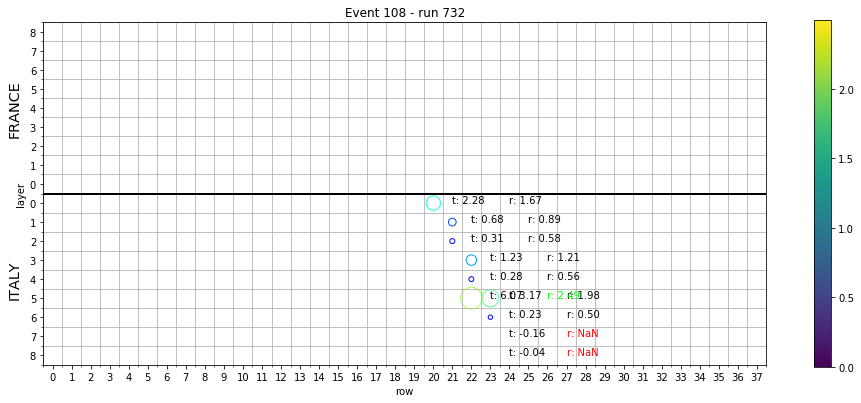

112


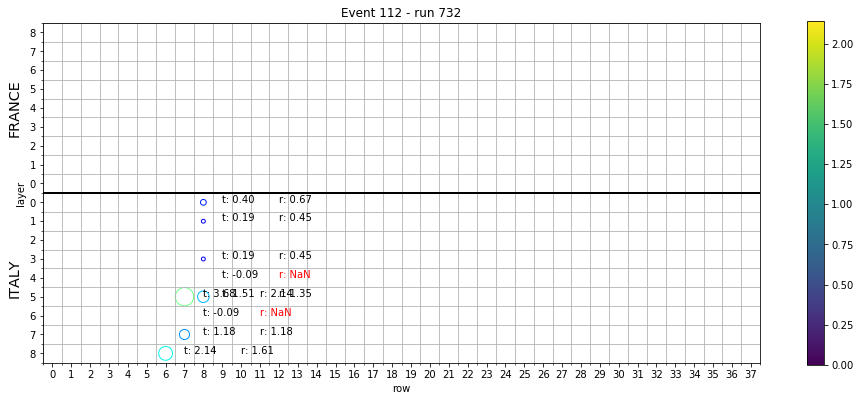

115


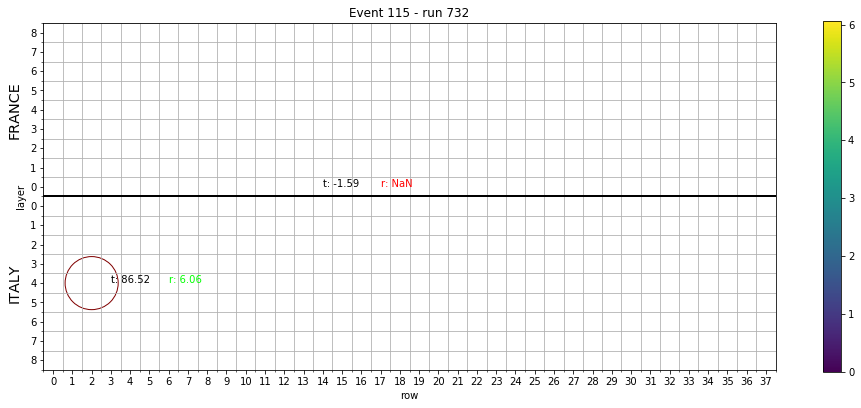

142


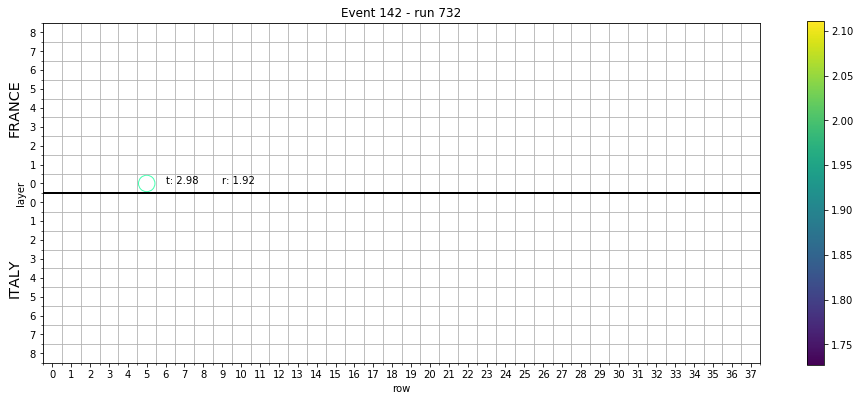

159


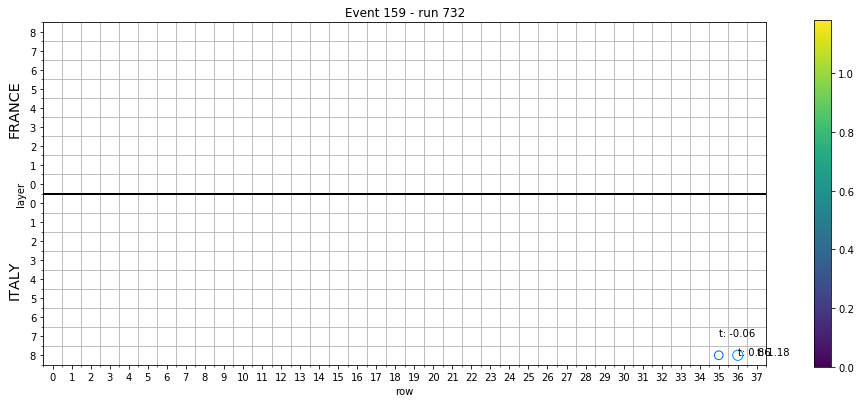

165


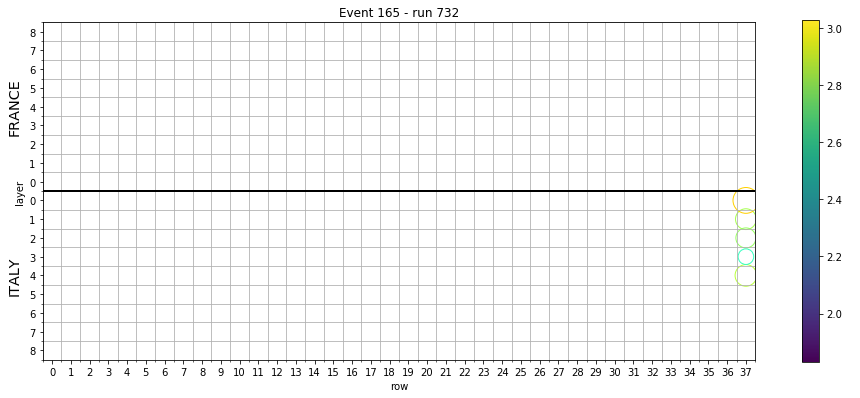

175


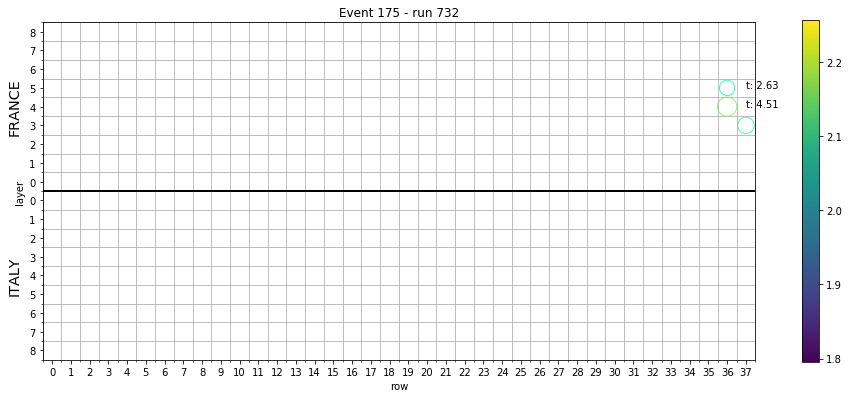

182


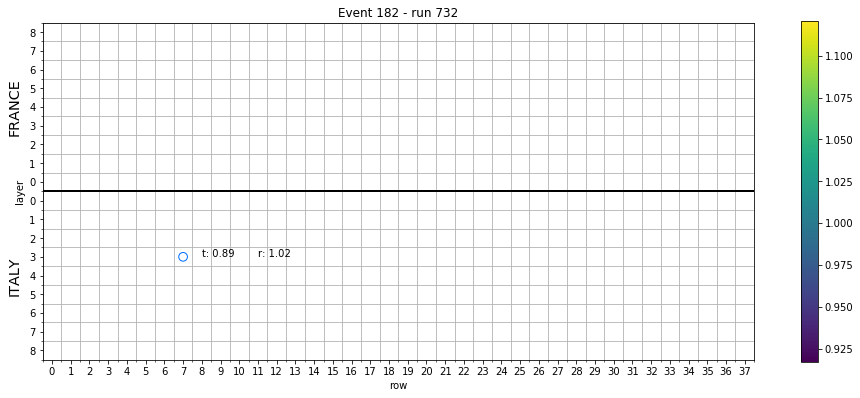

186


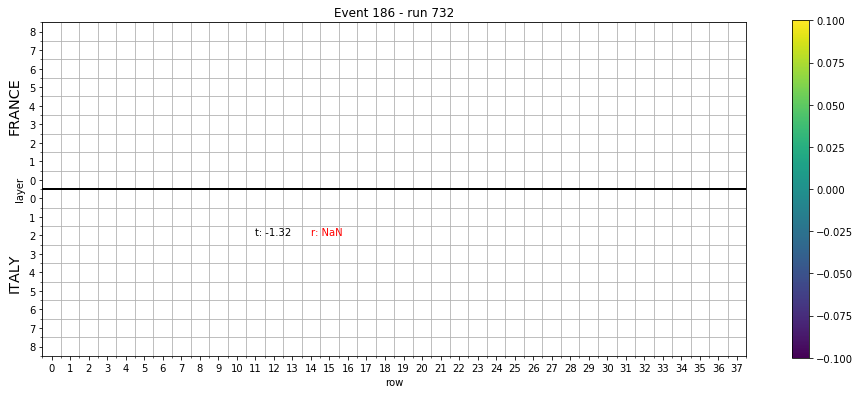

187


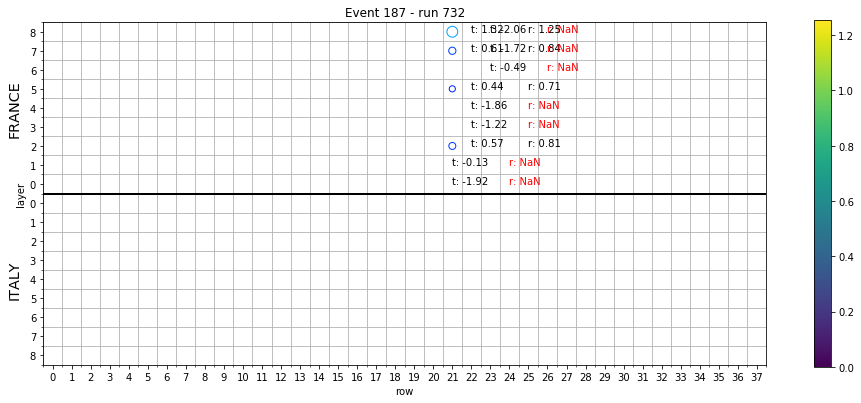

191


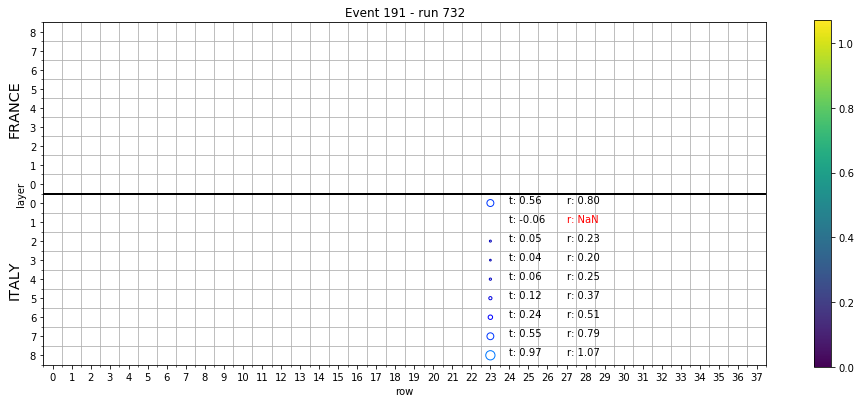

197


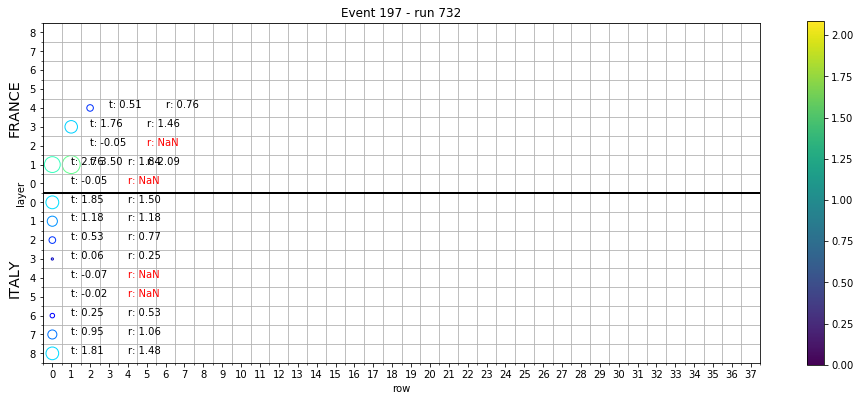

210


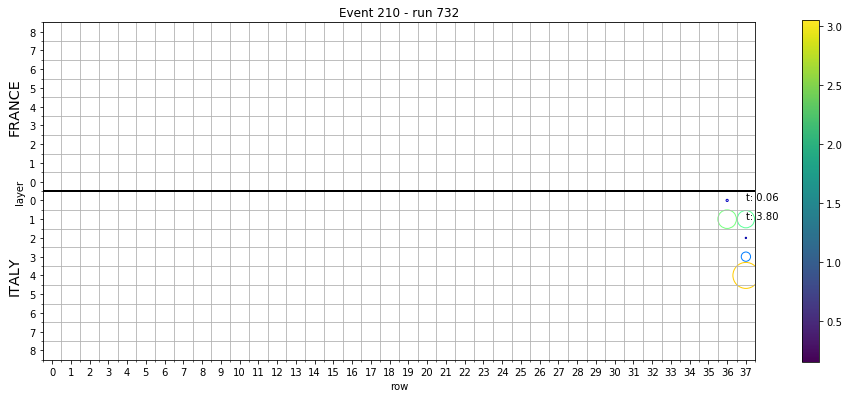

225


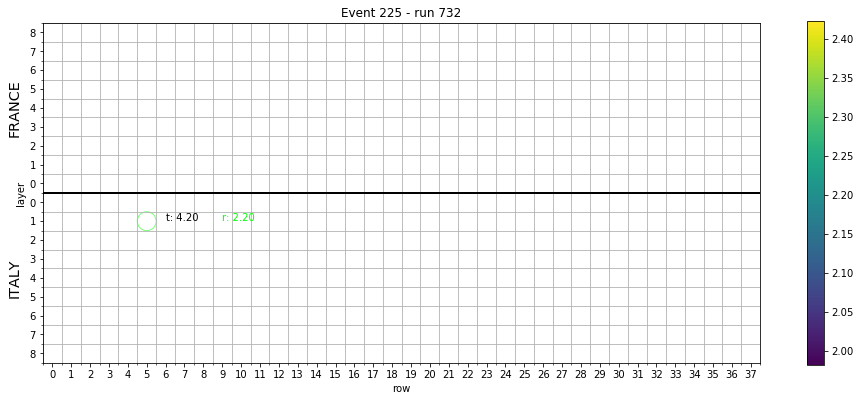

240


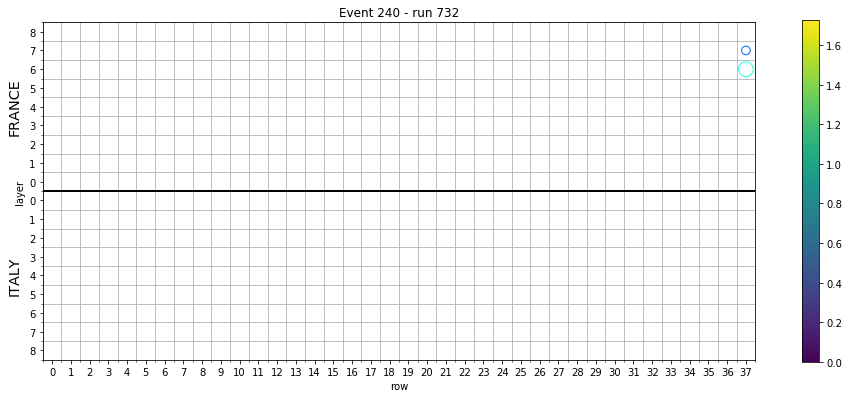

245


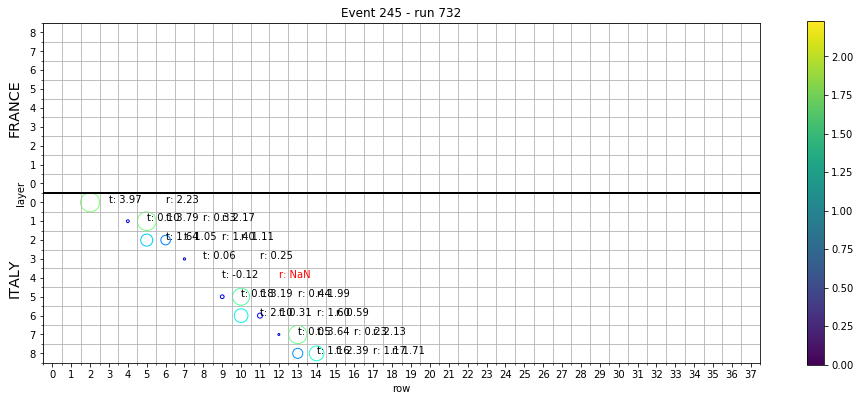

250


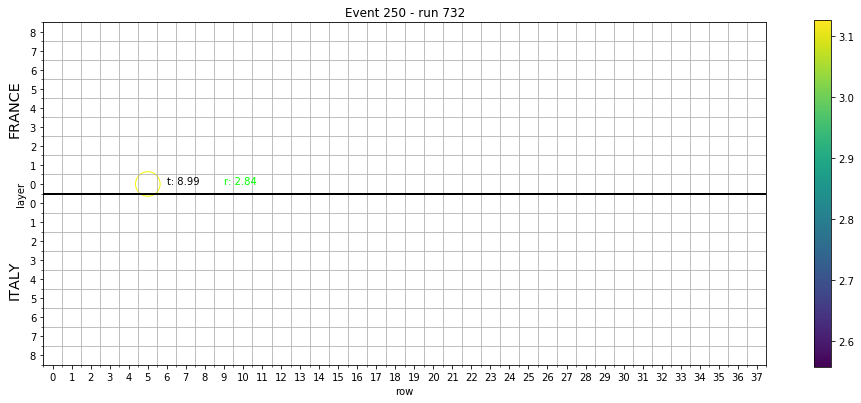

258


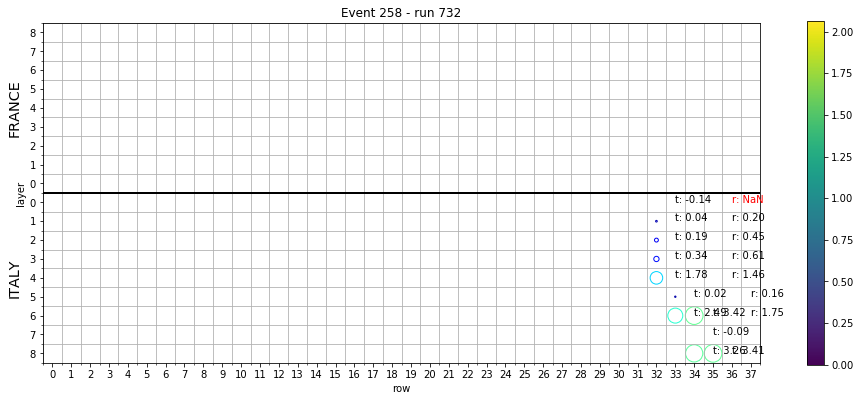

259


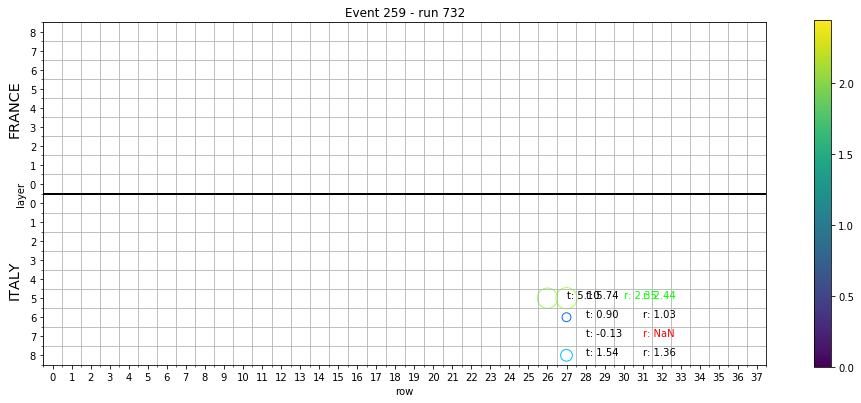

268


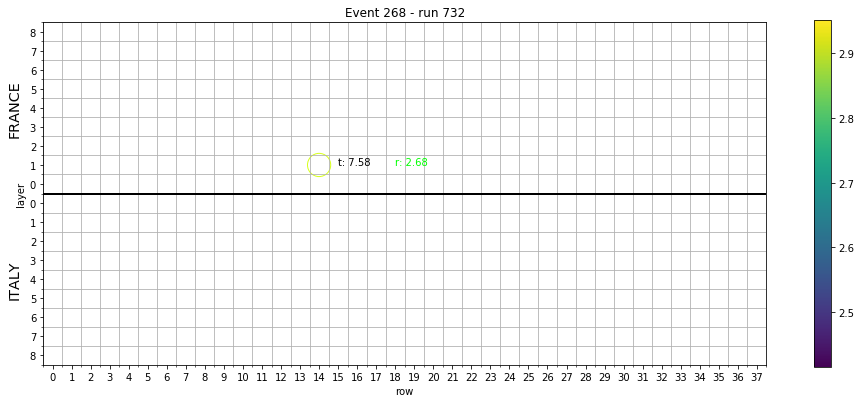

278


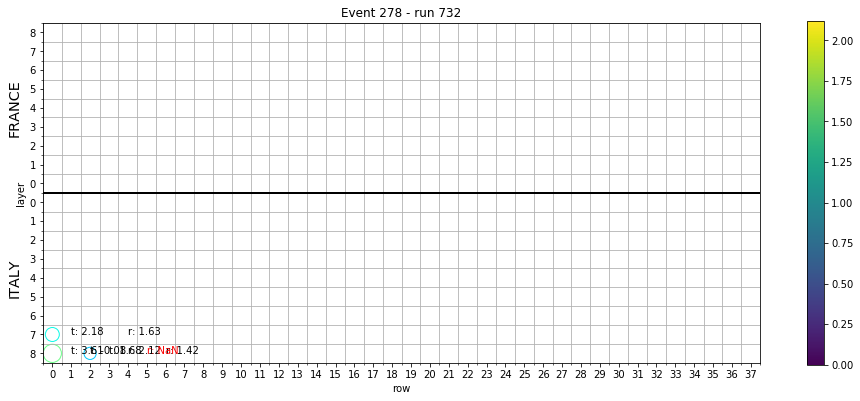

289


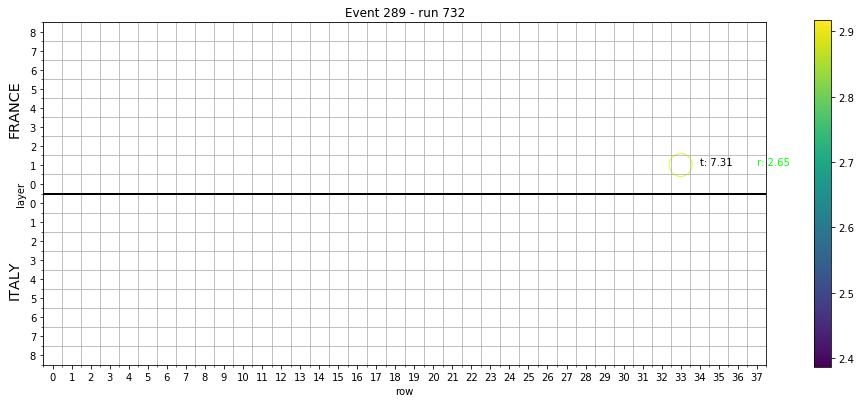

297


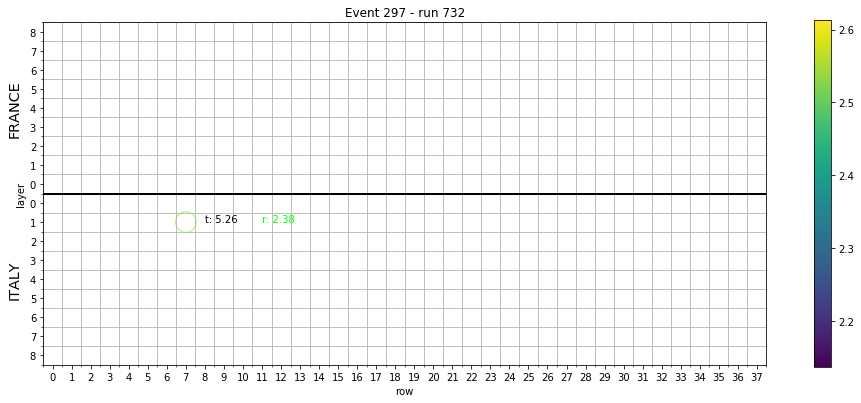

299


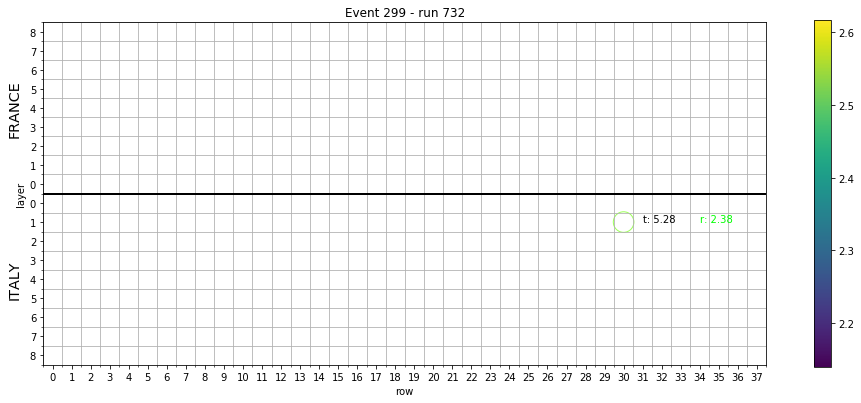

308


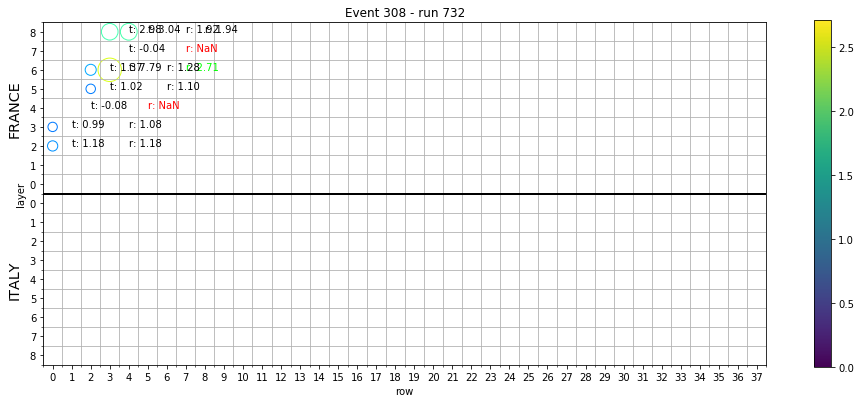

309


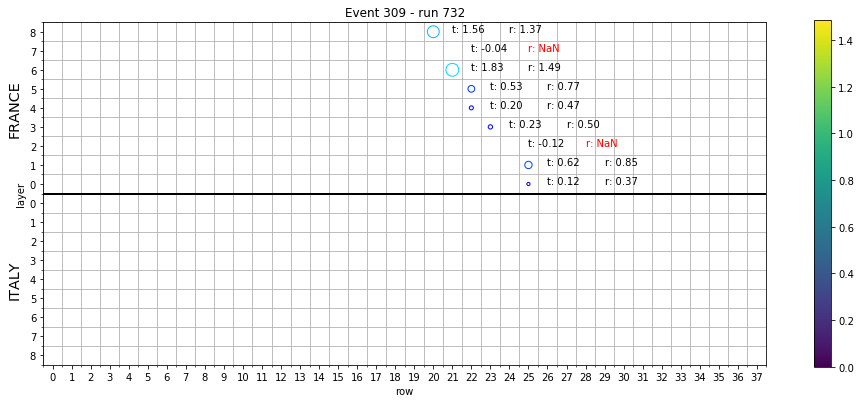

312


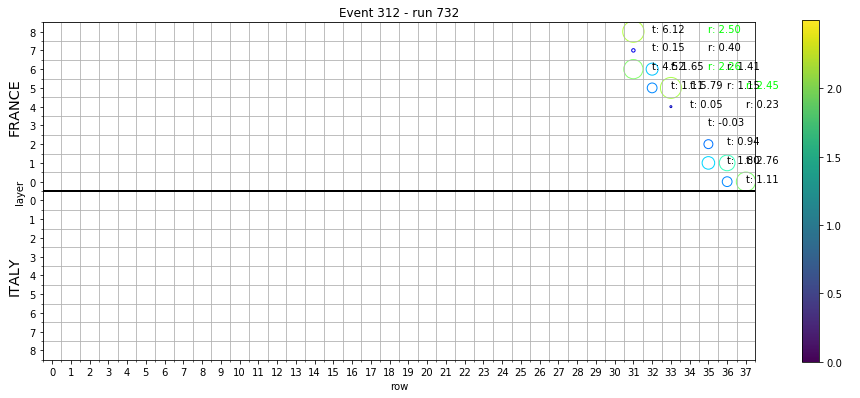

331


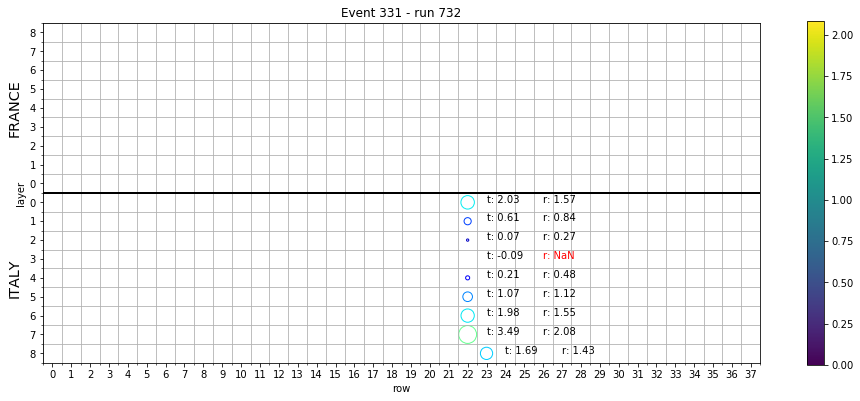

337


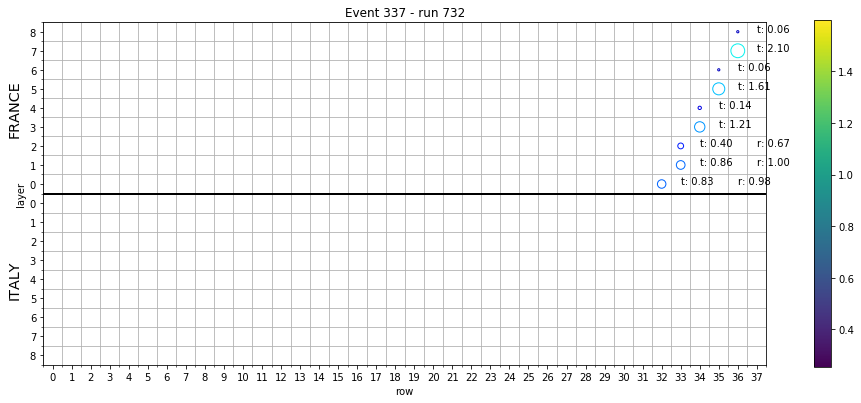

355


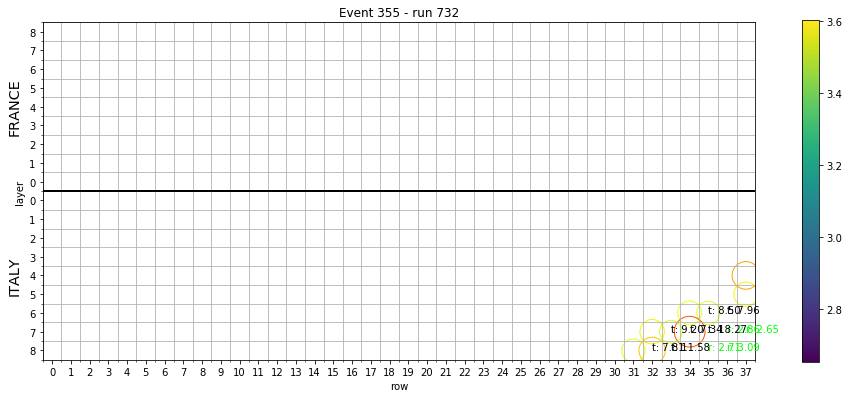

357


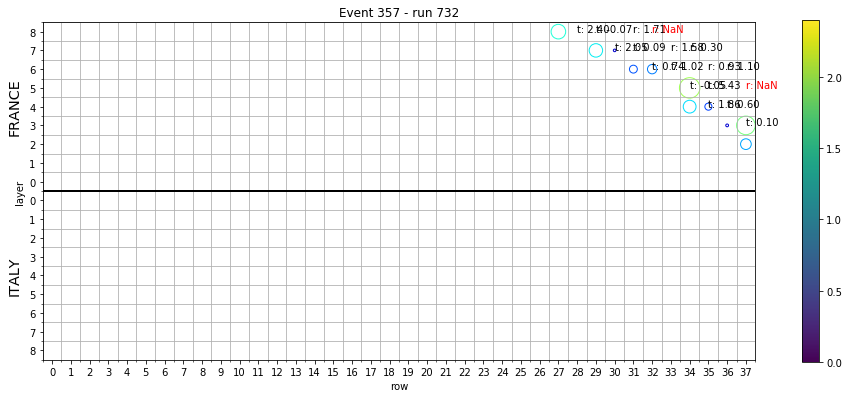

368


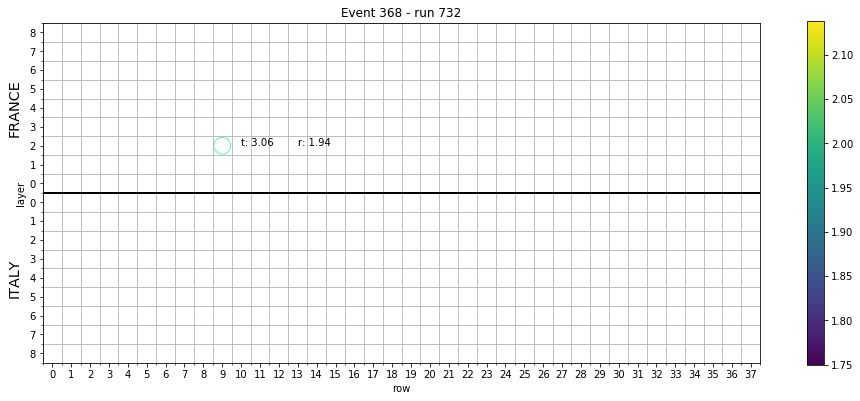

374


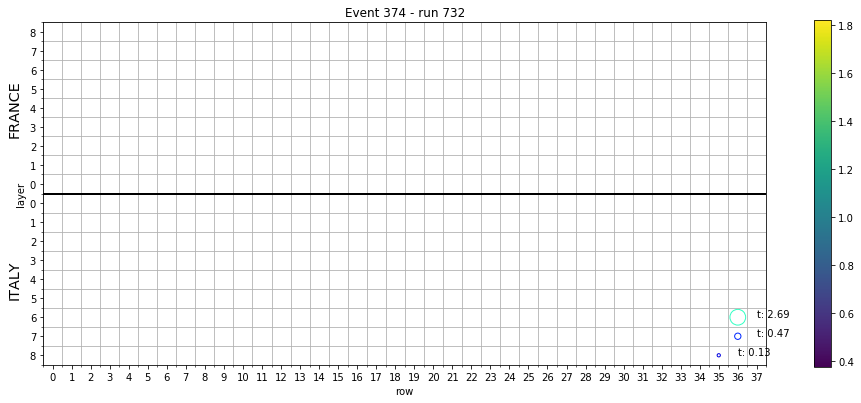

377


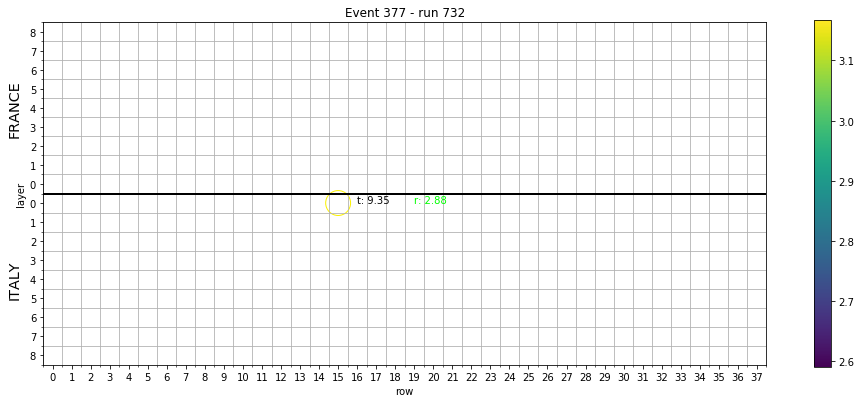

380


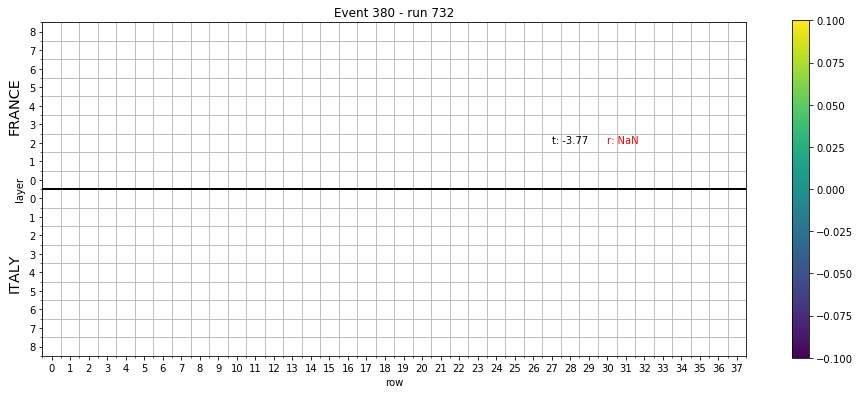

390


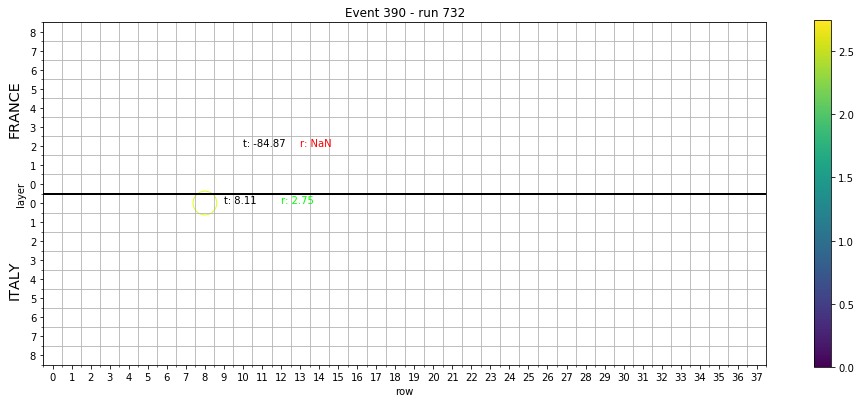

391


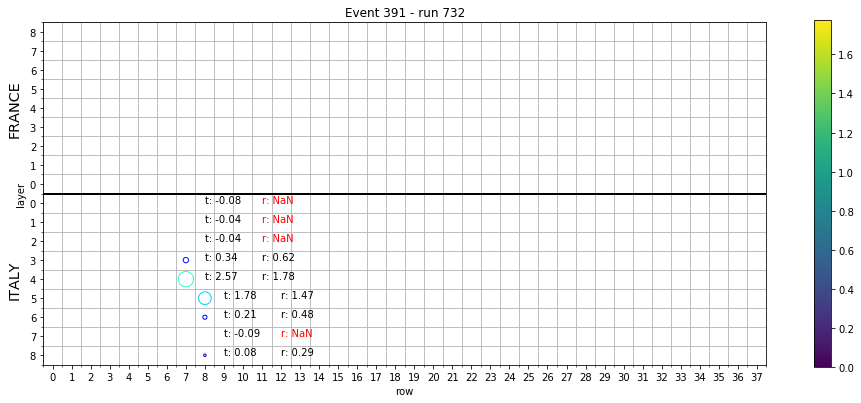

393


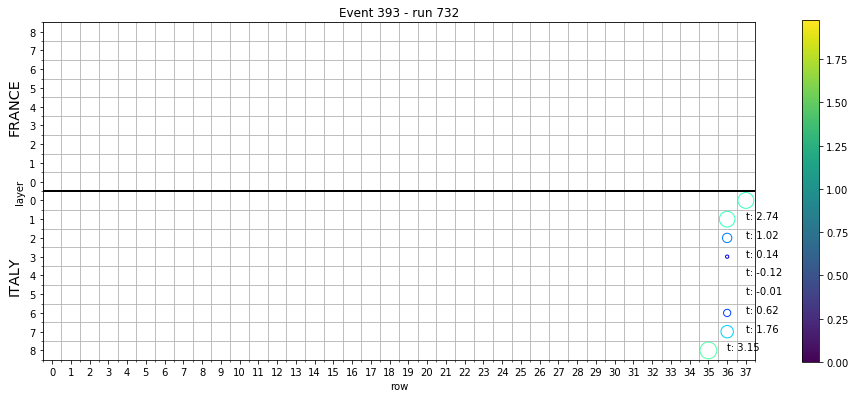

400


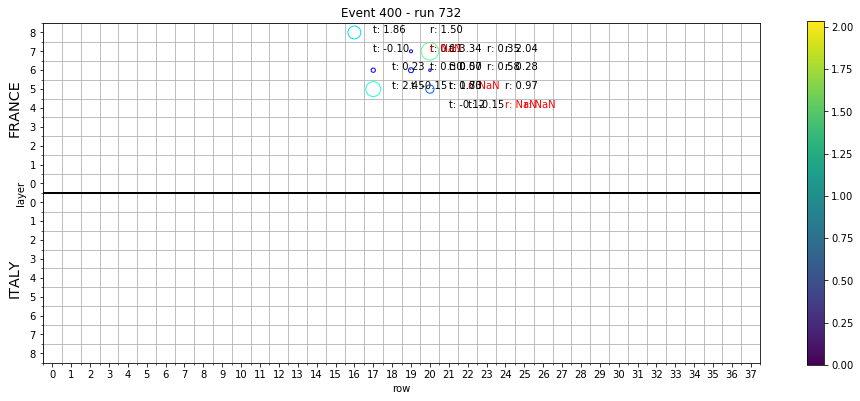

407


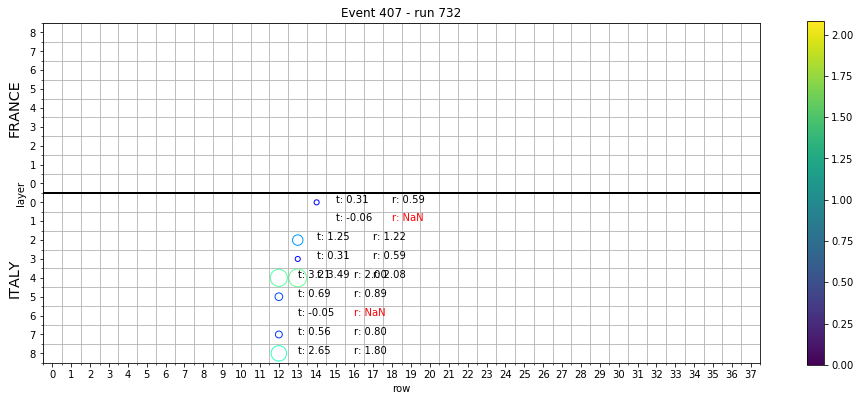

426


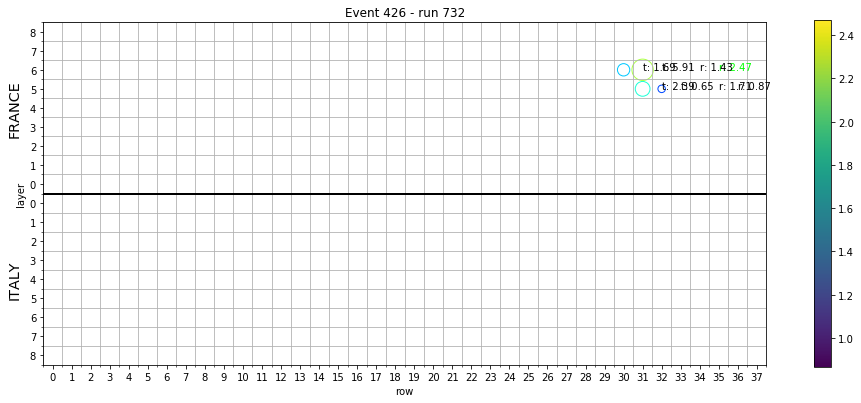

429


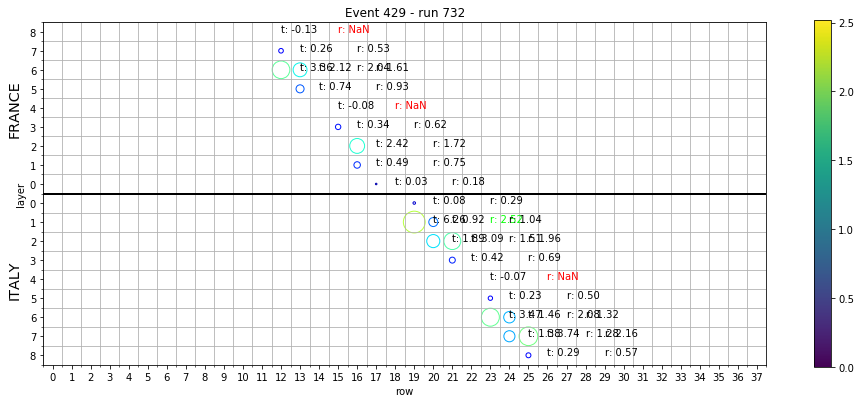

439


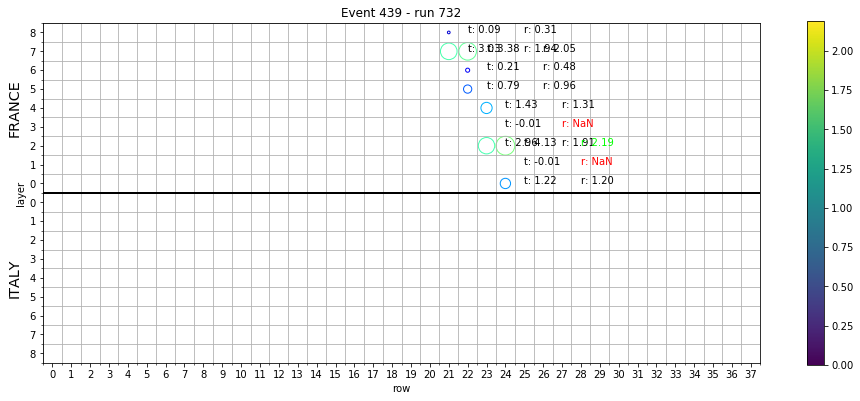

459



KeyboardInterrupt



<Figure size 864x1008 with 0 Axes>

In [64]:
#choose a range to look at here otherwise loop will take ages
for i in range(100,600):
    if get_good_events(i) == True:
        print(i)
        plot_xy_event_rad(i)

# Cathode plasma propagation time

Code to write the mean total propagation time for each cell to a file and to display the results as a 2D histogram

In [169]:
def write_mean_tpt_to_file(param='all events'):

    if param == 'all events':

        all_cell_nums = get_all_cell_nums()
        tpt_mega_list = [[] for i in range(len(all_cell_nums))]
        # mean_tdts = np.zeros(len(all_cell_nums))

        for event in tree:

            event_number = event.event_id

            layers = list(event.tracker_cell_layer_id) 
            rows = list(event.tracker_cell_row_id)
            sides = list(event.tracker_cell_side_id)
            cell_nums = LRS_to_num(layers, rows, sides)

            if len(layers) > 50: 
            # filter out certain events that have almost all of the cells triggered
                print(f'event {event_number} has {len(layers)} hits')
                continue

            r5 = list(event.tracker_bottom_cathode_R5_ticks)[::10]
            r6 = list(event.tracker_top_cathode_R6_ticks)[::10]
            r0 = list(event.tracker_anode_R0_ticks)[::10]

            for i in range(len(layers)):

                an_time = r0[i]*tdc2sec

                if an_time < 0 or (r5[i]*tdc2sec - an_time) < 0 or (r6[i]*tdc2sec - an_time) < 0:
                    continue

                tpt = ((r5[i]+r6[i])*tdc2sec - 2*an_time)*1e6
                ind = all_cell_nums.index(cell_nums[i])
                tpt_mega_list[ind].append(tpt)

        f = open(mean_tpts_file, 'w')

        for j in range(len(all_cell_nums)):

            if len(tpt_mega_list[j]) != 0:
                mean_tpt = np.mean(tpt_mega_list[j])
                tpt_stdev = np.std(tpt_mega_list[j])
                f.write('{} {:.4f} {:.4f}\n'.format(all_cell_nums[j], mean_tpt, tpt_stdev))
                tpt_file = tptdir + f'tpt_allevents_cell_{all_cell_nums[j]}.txt'
                np.savetxt(tpt_file, tpt_mega_list[j])

            else:
                f.write('{} nan nan\n'.format(all_cell_nums[j]))
                print(all_cell_nums[j], 'empty!')

        f.close()
    
    elif param == 'good tracks':

        filename = level2_tracks_file
        data = np.loadtxt(filename, dtype=str)
        e_nums, sides = data[:,0].astype(int), data[:,1].astype(int)

        all_cell_nums = get_all_cell_nums()
        tpt_mega_list = [[] for i in range(len(all_cell_nums))]
        mean_tpts = np.zeros(len(all_cell_nums))

        for i in range(len(e_nums)):

            event_number = e_nums[i]
            tree.GetEntry(event_number)
            n, l, r, s, top, bot = filter_track(event_number, sides[i])
            cell_nums = LRS_to_num(l, r, s)

            # if 1517 in cell_nums: print('\nThis one!\n')

            tpts = [top[i] + bot[i] for i in range(len(top))]
            for j in range(len(cell_nums)):

                ind = all_cell_nums.index(cell_nums[j])
                tpt_mega_list[ind].append(tpts[j])

        f = open(mean_tpts_goodtracks_file, 'w')

        for z in range(len(all_cell_nums)):

            if len(tpt_mega_list[z]) != 0:
                mean_tpt = np.mean(tpt_mega_list[z])
                tpt_stdev = np.std(tpt_mega_list[z])
                mean_tpts[z] = mean_tpt
                f.write('{} {:.4f} {:.4f}\n'.format(all_cell_nums[z], mean_tpt, tpt_stdev))

                tdt_file = tptdir + f'tpt_goodtracks_cell_{all_cell_nums[z]}.txt'
                np.savetxt(tdt_file, tpt_mega_list[z])

            else:
                f.write('{} nan nan\n'.format(all_cell_nums[z]))
                print(all_cell_nums[z], 'empty!')

        f.close()

def get_bad_cells_tpt():

    bad_cell_list = []

    all_cell_nums = np.array(get_all_cell_nums())
    for cell_num in all_cell_nums:
        tpt_file = tptdir + f'tpt_allevents_cell_{cell_num}.txt'
        if Path(tpt_file).exists() == False: 
            bad_cell_list.append(cell_num)
    return bad_cell_list

def tpt_errors(tpts, cells_list):

    # define the error as proportional to the distance of the tdt to the mean tdt for that cell
    filename = filedir+'mean_tdts.txt'
    data = np.loadtxt(filename, dtype=float)
    cell_nums, mean_tpts, tpt_stdevs = data[:,0].astype(int), data[:,1], data[:,2]

    errors = []

    for i in range(len(tpts)):
        tdt_err = tpt_stdevs[cell_nums==cells_list[i]][0]
        errors.append(tdt_err)

    return errors

def colour_plot_tpts():

    # more stuff to do here if you've got the time

    data = np.loadtxt('mean_tdts.txt', dtype=float)
    cell_nums, mean_tdts, stdevs = np.array(data[:,0].astype(int)), np.array(data[:,1]), np.array(data[:,2])
    num_bars = len(cell_nums)
    l, r, s = num_to_LRS(cell_nums)
    l = adjusted_layers(l, s)

    bad_indices = np.isnan(mean_tdts) 
    good_indices = ~bad_indices  # remove the nan values

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    zmin = mean_tdts[good_indices].min() #40
    zmax = mean_tdts[good_indices].max()

    xs = np.arange(-.5, 37.5, 0.1)
    zs = np.arange(zmin, int(zmax)+0.1, 0.1)
    X, Z = np.meshgrid(xs, zs)
    Y = np.zeros_like(X)
    ax.plot_surface(X, Y, Z, alpha=0.5, color='k')

    major_xticks = np.arange(0,38)
    minor_xticks = np.arange(-.5,38.5)
    major_yticks = np.arange(-8.5,9.5)
    minor_yticks = np.arange(-9,10)
    layer_ticks = [8, 7, 6, 5, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8]

    ax.set_xlim(-.5,37.5)
    ax.set_ylim(-8.5,8.5)
    ax.set_xticks(major_xticks)
    ax.set_yticks(major_yticks)
    # ax.set_xticks(minor_xticks, minor = True)
    # ax.set_yticks(minor_yticks, minor = True)
    ax.set_yticklabels(layer_ticks)
    ax.xaxis.grid(which='minor')
    ax.yaxis.grid(which='minor')

    # ax.set_zlim(0, tracker_height)
    ax.set_xlabel('Row number')
    ax.set_ylabel('Layer number')
    ax.set_zlabel('Mean total propagation time')
    title = 'Histogram of total propagation times across all cells'

    x, y, z = r[good_indices]-.25, l[good_indices]-.25, zmin #np.zeros(num_bars)
    dx, dy, dz = np.ones_like(z)*1/2, np.ones_like(z)*1/2, mean_tdts[good_indices] - zmin

    # print(x,y,z,dx,dy,dz)

    cmap = cm.get_cmap('viridis')
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    rgba = [cmap((k-min_height)/max_height) for k in dz]

    ax.bar3d(x, y, z, dx, dy, dz, zsort='average', color=rgba) 
    ax.text(0, -4, 80, 'Italy',  fontsize='large', horizontalalignment='center', verticalalignment='center', fontfamily='serif')
    ax.text(0, +4, 80, 'France', fontsize='large', horizontalalignment='center', verticalalignment='center', fontfamily='serif')

    ax.view_init(60,-20)

    fig.savefig(plotsdir+'hist3D_mean_tdts.png')

    plt.show()

def hist2D_tpts(param='all events'):

    all_cell_nums = np.array(get_all_cell_nums())
    l, r, s = num_to_LRS(all_cell_nums)
    l = adjusted_layers(l, s)
    mean_tpts = []

    print('Bad cells:')

    for cell_num in all_cell_nums:

        if param == 'all events':
            tpt_file = tptdir + f'tpt_allevents_cell_{cell_num}.txt'
        elif param == 'good tracks':
            tpt_file = tptdir + f'tpt_goodtracks_cell_{cell_num}.txt'
        if Path(tpt_file).exists() == False: 
            mean_tpts.append(np.nan)
            print(f'{cell_num}', end=' ')
            continue
        tpts = np.loadtxt(tpt_file)

        mean_tpts.append(np.mean(tpts))

    mean_tpts = np.array(mean_tpts)
    bad_indices = np.isnan(mean_tpts) 
    good_indices = ~bad_indices  # remove the nan values
    # overall_mean = np.mean(mean_tpts[good_indices])

    # print('\nMean residual error for a cell: {:.4f}\n'.format(overall_mean))

    layer_ticks = [8,7,6,5,4,3,2,1,0,0,1,2,3,4,5,6,7,8]

    rows = np.arange(min_row,max_row+1)
    layers = np.arange(-8.5,9.5)
    Z_ = mean_tpts.reshape(18, (max_row-min_row+1))
    Z = np.empty_like(Z_)
    Z[:9,:] = np.flipud(Z_[:9,:])
    Z[9:,:] = Z_[9:,:]

    fig, ax = plt.subplots(figsize=(10,6), tight_layout=True) # 
    title = f'Mean cathode total propagation time (µs) - run {run_number}'

    c = ax.pcolormesh(rows, layers, Z, edgecolors='k', linewidths=1, cmap='plasma')
    ax.plot(np.arange(min_row-.5,max_row+1.5), np.zeros_like(np.arange(min_row-.5,max_row+1.5)), 'k', linewidth=4) # source foil line
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    cbar = fig.colorbar(c, cax=cax)

    ax.set_title(title, fontsize='large')
    ax.set_xlabel('rows')
    ax.set_ylabel('layers')
    ax.set_yticks(layers, layer_ticks)
    ax.set_xticks(rows, rows)
    ax.text(-.04, 0.75, 'FRANCE', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.text(-.04, 0.25, 'ITALY', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.set_aspect(1)

    fig.savefig(plotsdir+f'hist2d_tpts_{param}_run{run_number}.png', transparent=False)

    plt.show()

def check_malfunctioning_cell(cell_num):

    print(f'** Cell {cell_num} **')

    anode_hits, neg_anode_hits = 0, 0
    top_cath_hits, neg_top_cath_hits = 0, 0
    bot_cath_hits, neg_bot_cath_hits = 0, 0

    for event in tree:

        layers = list(event.tracker_cell_layer_id) 
        rows = list(event.tracker_cell_row_id)
        sides = list(event.tracker_cell_side_id)
        cell_nums = LRS_to_num(layers, rows, sides)

        if cell_num not in cell_nums:
            continue

        anode_hits += 1; top_cath_hits += 1; bot_cath_hits += 1

        r5 = list(event.tracker_bottom_cathode_R5_ticks)[::10]
        r6 = list(event.tracker_top_cathode_R6_ticks)[::10]
        r0 = list(event.tracker_anode_R0_ticks)[::10]
        an_timestamp = r0[cell_nums.index(cell_num)]
        top_timestamp = r6[cell_nums.index(cell_num)]
        bot_timestamp = r5[cell_nums.index(cell_num)]

        if an_timestamp < 0: neg_anode_hits += 1
        if top_timestamp < 0: neg_top_cath_hits += 1
        if bot_timestamp < 0: neg_bot_cath_hits += 1

    print(f'''
{anode_hits} anode hits, {neg_anode_hits} negative
{top_cath_hits} top cathode hits, {neg_top_cath_hits} negative
{bot_cath_hits} bot cathode hits, {neg_bot_cath_hits} negative
    ''')

    if anode_hits != 0:
        if neg_anode_hits / anode_hits == 1.:
            print(f'broken anode')
    if top_cath_hits != 0:
        if neg_top_cath_hits / top_cath_hits == 1.:
            print(f'broken top cathode')
    if bot_cath_hits != 0:
        if neg_bot_cath_hits / bot_cath_hits == 1.:
            print(f'broken bottom cathode')

def check_malfunctioning_cells(cell_list):

    broken_anodes, broken_top_caths, broken_bot_caths, zero_hits = [], [], [], []

    hits_list = np.zeros_like(cell_list)
    neg_an_hits_list = np.zeros_like(cell_list) # negative anode
    neg_tc_hits_list = np.zeros_like(cell_list) # negative top cathode
    neg_bc_hits_list = np.zeros_like(cell_list) # negative bot cathode

    for event in tree:

        layers = list(event.tracker_cell_layer_id) 
        rows = list(event.tracker_cell_row_id)
        sides = list(event.tracker_cell_side_id)
        cell_nums = LRS_to_num(layers, rows, sides)
        r5 = list(event.tracker_bottom_cathode_R5_ticks)[::10]
        r6 = list(event.tracker_top_cathode_R6_ticks)[::10]
        r0 = list(event.tracker_anode_R0_ticks)[::10]

        for cell_num in cell_list:

            if cell_num in cell_nums:

                index = cell_list.index(cell_num)

                hits_list[index] += 1

        # anode_hits += 1; top_cath_hits += 1; bot_cath_hits += 1
        
                an_timestamp = r0[cell_nums.index(cell_num)]
                top_timestamp = r6[cell_nums.index(cell_num)]
                bot_timestamp = r5[cell_nums.index(cell_num)]

                if an_timestamp < 0: neg_an_hits_list[index] += 1
                if top_timestamp < 0: neg_tc_hits_list[index] += 1
                if bot_timestamp < 0: neg_bc_hits_list[index] += 1

    for i in range(len(cell_list)):

        cell = cell_list[i]
        hits = hits_list[i]
        neg_an_hits = neg_an_hits_list[i]
        neg_tc_hits = neg_tc_hits_list[i]
        neg_bc_hits = neg_bc_hits_list[i]

        print(f'Cell {cell}:')

        print(f'{hits} hits, {neg_an_hits} neg an, {neg_tc_hits} neg tc, {neg_bc_hits} neg bc')

        if hits == 0:
            zero_hits.append(cell)
        else:
            if neg_an_hits / hits > 0.9: # above 90% are negative
                print(f'broken anode')
                broken_anodes.append(cell)
            if neg_tc_hits / hits > 0.9:
                print(f'broken top cathode')
                broken_top_caths.append(cell)
            if neg_bc_hits / hits > 0.9:
                print(f'broken bot cathode')
                broken_bot_caths.append(cell)
        print()

    return zero_hits, broken_anodes, broken_top_caths, broken_bot_caths

def hist2D_tpts_with_bad_cells(zero_hits, broken_an, broken_tc, broken_bc):

    all_cell_nums = np.array(get_all_cell_nums())
    l, r, s = num_to_LRS(all_cell_nums)
    l = adjusted_layers(l, s)
    mean_tpts = []

    no_hits_l, no_hits_r, no_hits_s = num_to_LRS(zero_hits)
    no_hits_l = adjusted_layers(no_hits_l, no_hits_s)
    bad_an_l, bad_an_r, bad_an_s = num_to_LRS(broken_an)
    bad_an_l = adjusted_layers(bad_an_l, bad_an_s)
    bad_tc_l, bad_tc_r, bad_tc_s = num_to_LRS(broken_tc)
    bad_tc_l = adjusted_layers(bad_tc_l, bad_tc_s)
    bad_bc_l, bad_bc_r, bad_bc_s = num_to_LRS(broken_bc)
    bad_bc_l = adjusted_layers(bad_bc_l, bad_bc_s)

    for cell_num in all_cell_nums:

        tpt_file = tptdir + f'tpt_allevents_cell_{cell_num}.txt'
        if Path(tpt_file).exists() == False: 
            mean_tpts.append(np.nan)
            continue
        tpts = np.loadtxt(tpt_file)

        mean_tpts.append(np.mean(tpts))

    mean_tpts = np.array(mean_tpts)

    layer_ticks = [8,7,6,5,4,3,2,1,0,0,1,2,3,4,5,6,7,8]

    rows = np.arange(min_row,max_row+1)
    layers = np.arange(-8.5,9.5)
    Z_ = mean_tpts.reshape(18, (max_row-min_row+1))
    Z = np.empty_like(Z_)
    Z[:9,:] = np.flipud(Z_[:9,:])
    Z[9:,:] = Z_[9:,:]

    fig, ax = plt.subplots(figsize=(10,6), tight_layout=True) # 
    title = f'Mean cathode total propagation time (µs) - run {run_number}'

    c = ax.pcolormesh(rows, layers, Z, edgecolors='k', linewidths=1, cmap='plasma')
    ax.plot(np.arange(min_row-.5,max_row+1.5), np.zeros_like(np.arange(min_row-.5,max_row+1.5)), 'k', linewidth=4) # source foil line

    ax.scatter(bad_an_r, bad_an_l, marker = 'o', color = 'k', label = 'broken anode')
    ax.scatter(bad_tc_r, bad_tc_l, marker = '^', color = 'k', label = 'broken top cathode')
    ax.scatter(bad_bc_r, bad_bc_l, marker = 'v', color = 'k', label = 'broken bottom cathode')
    ax.scatter(no_hits_r, no_hits_l, marker = 'x', color = 'k', label = 'zero hits')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    cbar = fig.colorbar(c, cax=cax)

    ax.set_title(title, fontsize='large')
    ax.set_xlabel('rows')
    ax.set_ylabel('layers')
    ax.set_yticks(layers, layer_ticks)
    ax.set_xticks(rows, rows)
    ax.text(-.04, 0.75, 'FRANCE', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.text(-.04, 0.25, 'ITALY', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.set_aspect(1)

    # ax.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

    fig.savefig(plotsdir+f'hist2d_tpts_badcells_run{run_number}.png', transparent=False)

    plt.show()

In [48]:
# write_mean_tpt_to_file('all events')
# hist2D_tpts('all events')
# check_malfunctioning_cell(297)

In [231]:
bad_cell_list = get_bad_cells_tpt()
zero_hits, broken_anodes, broken_top_caths, broken_bot_caths = check_malfunctioning_cells(bad_cell_list)


Cell 27:
0 hits, 0 neg an, 0 neg tc, 0 neg bc

Cell 45:
1150 hits, 128 neg an, 1150 neg tc, 98 neg bc
broken top cathode

Cell 81:
1 hits, 0 neg an, 0 neg tc, 0 neg bc

Cell 99:
2 hits, 2 neg an, 2 neg tc, 0 neg bc
broken anode
broken top cathode

Cell 153:
1182 hits, 42 neg an, 1182 neg tc, 782 neg bc
broken top cathode

Cell 189:
1155 hits, 154 neg an, 92 neg tc, 1155 neg bc
broken bot cathode

Cell 297:
1113 hits, 27 neg an, 1113 neg tc, 92 neg bc
broken top cathode

Cell 306:
1142 hits, 34 neg an, 1142 neg tc, 113 neg bc
broken top cathode

Cell 10:
1 hits, 1 neg an, 1 neg tc, 0 neg bc
broken anode
broken top cathode

Cell 19:
0 hits, 0 neg an, 0 neg tc, 0 neg bc

Cell 28:
708 hits, 4 neg an, 677 neg tc, 690 neg bc
broken top cathode
broken bot cathode

Cell 82:
1297 hits, 104 neg an, 112 neg tc, 1296 neg bc
broken bot cathode

Cell 74:
85 hits, 3 neg an, 65 neg tc, 78 neg bc
broken bot cathode

Cell 299:
2005 hits, 809 neg an, 2005 neg tc, 113 neg bc
broken top cathode

Cell 21:
8

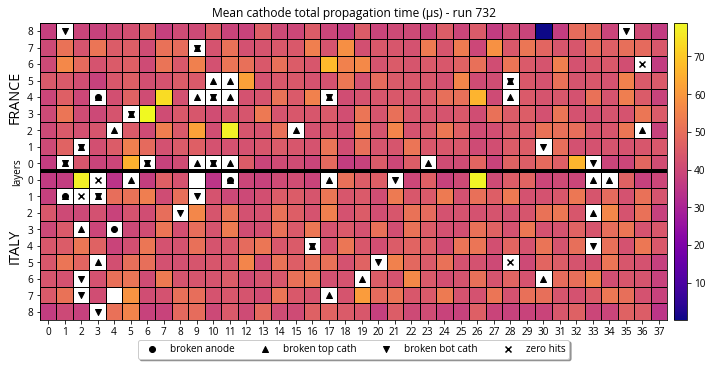

In [56]:
hist2D_tpts_with_bad_cells(zero_hits, broken_anodes, broken_top_caths, broken_bot_caths)

bad cell list (no recorded TPT):


run 730:

27 45 81 99 153 189 297 306 10 19 28 82 74 299 21 39 148 301 32 185 257 24 177 276 25 160 35 1026 1071 1098 1107 1116 1224 1314 1036 1288 1055 1154 1343 1048 1102 1111 1120 1174 1273 1112 1121 1274 1347 1105 1034 1295 1340

run 731: 

27 45 81 99 153 189 297 306 10 19 28 82 74 299 21 39 148 301 32 185 257 24 177 276 25 43 160 35 1026 1071 1098 1107 1116 1224 1314 1036 1288 1055 1154 1343 1048 1102 1111 1120 1174 1273 1112 1121 1274 1347 1105 1034 1295 1340 

run 732: 

27 45 81 99 153 189 297 306 10 19 28 82 74 299 21 39 148 301 32 185 257 24 177 276 25 43 160 35 1026 1071 1098 1107 1116 1224 1314 1036 1288 1055 1154 1343 1065 1048 1102 1111 1120 1174 1273 1112 1121 1274 1347 1105 1034 1340 

43 added to 731 and 732, 1065 added to 732 list but 1295 not in 732



In [254]:
calc_cell_num(3,32,0)

# for event in tree:

#     layers = list(event.tracker_cell_layer_id) 
#     rows = list(event.tracker_cell_row_id)
#     sides = list(event.tracker_cell_side_id)
#     cell_nums = LRS_to_num(layers, rows, sides)

#     if len(cell_nums) > 50: print(event.event_id)

291

# Hits in the tracker chambers

Looks at the total hits registered during the run, to identify the participation of cells to all events.

useful for identifying malfunctioning cells (disconnected, 'hot', or else)

In [12]:
def write_hits_cells_tofile(param='all', with_limit=False):

    filename = filedir+f'hits_cells_{param}.txt'
    if with_limit: filename = filedir+f'hits_cells_{param}_max50.txt'
    f = open(filename, 'w')

    all_cell_nums = np.array(get_all_cell_nums())
    hits_counts = np.zeros_like(all_cell_nums)

    if param == 'all':

        for event in tree:

            layers = list(event.tracker_cell_layer_id) 
            rows = list(event.tracker_cell_row_id)
            sides = list(event.tracker_cell_side_id)
            cell_nums = LRS_to_num(layers, rows, sides)

            if len(cell_nums) > 50: continue

            for cell in cell_nums:
                hits_counts[all_cell_nums==cell] += 1

        for i in range(len(all_cell_nums)):
            f.write('{} {}\n'.format(all_cell_nums[i], hits_counts[i]))

    f.close()

def hist2D_hits(param='all', with_limit=False):

    filename = filedir+f'hits_cells_{param}.txt'
    if with_limit: filename = filedir+f'hits_cells_{param}_max50.txt'
    data = np.loadtxt(filename, dtype=float)
    cells, counts = data[:,0], data[:,1]
    fractions = counts / n_events
    fractions[fractions==0] = np.nan

    layer_ticks = [8,7,6,5,4,3,2,1,0,0,1,2,3,4,5,6,7,8]

    rows = np.arange(min_row,max_row+1)
    layers = np.arange(-8.5,9.5)
    Z_ = fractions.reshape(18, (max_row-min_row+1))
    Z = np.empty_like(Z_)
    Z[:9,:] = np.flipud(Z_[:9,:])
    Z[9:,:] = Z_[9:,:]

    fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
    title = f'Fraction of cell participation to all hits - run {run_number}'

    c = ax.pcolormesh(rows, layers, Z, edgecolors='k', linewidths=1, cmap='viridis')
    ax.plot(np.arange(min_row-.5,max_row+1.5), np.zeros_like(np.arange(min_row-.5,max_row+1.5)), 'k', linewidth=4) # source foil line
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    cbar = fig.colorbar(c, cax=cax)
    ax.set_title(title, fontsize='large')
    ax.set_xlabel('rows')
    ax.set_ylabel('layers')
    ax.set_yticks(layers, layer_ticks)
    ax.set_xticks(rows, rows)
    ax.text(-.04, 0.75, 'FRANCE', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.text(-.04, 0.25, 'ITALY', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.set_aspect(1)

    if with_limit:
        fig.savefig(plotsdir+f'hist2d_hits_{param}_max50.png')
    else:
        fig.savefig(plotsdir+f'hist2d_hits_{param}.png')

    plt.show()

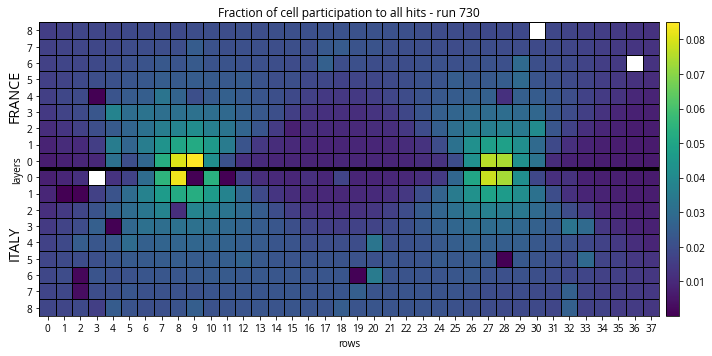

In [13]:
write_hits_cells_tofile()
hist2D_hits()

# Residuals analysis

Looking at the residuals (across all cells) from a linear fit performed to the vertical trajectory of electrons

In [313]:
def hist_resids_cell_fromfile(cell_num):

    layer, row, side = cell_num % (9 * 113) % 9, cell_num % (9 * 113) // 9, cell_num // (9 * 113)
    side_str = 'France' if side==1 else 'Italy'

    resid_file = residdir + f'residuals_cell_{cell_num}.txt'
    resids = np.loadtxt(resid_file)*100 #cm

    mean_resid, resid_std = np.mean(resids), np.std(resids)
    print('\nCell Number: {}\nMean residual error = {:.4f} / stdev = {:.4f}\n'.format(cell_num, mean_resid, resid_std))

    fig = plt.figure(figsize=(5,6), tight_layout=True) # 
    plt.hist(resids, bins=25, color='indigo', histtype='step') # range=[-30,30]
    plt.axvline(5, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(-5, color='k', linestyle='dashed', linewidth=1)
    plt.xlabel('vertical residuals /cm')
    plt.ylabel('counts')
    plt.xlim(-5,5)
    plt.title('Cell {} (row {}, layer {}, {})'.format(cell_num, row, layer, side_str))
    plt.text(3, 25, r'$\sigma = {:.2f} cm$'.format(resid_std), color='k', fontsize='x-large', horizontalalignment='center', verticalalignment='center')

    # fig.savefig(plotsdir+f'hist_resids_cell_{cell_num}_withsign_{param}.png')
    plt.show()

def hist2D_cells_resids(bad_cells_list, min_resids=50, param='good tracks'):

    all_cell_nums = np.array(get_all_cell_nums())
    l, r, s = num_to_LRS(all_cell_nums)
    l = adjusted_layers(l, s)
    stdev_resids, mean_resids, sigmas = [], [], []
    number_of_resids = []
    low_count_cells = []
    number_lowcount_cells = 0

    badtpt_l, badtpt_r, badtpt_s = num_to_LRS(bad_cells_list)
    badtpt_l = adjusted_layers(badtpt_l, badtpt_s)

    for cell_num in all_cell_nums:

        if param == 'onerow':
            resid_file = residdir + f'residuals_onerow_cell_{cell_num}.txt'
        else:
            resid_file = residdir + f'residuals_cell_{cell_num}.txt'

        if Path(resid_file).exists() == False:
            stdev_resids.append(np.nan); mean_resids.append(np.nan); sigmas.append(np.nan)
            # print(f'bad cell: {cell_num}')
            continue

        if cell_num in [291]:
            stdev_resids.append(np.nan); mean_resids.append(np.nan); sigmas.append(np.nan)
            continue

        residuals = np.loadtxt(resid_file)

        if residuals.size > min_resids: 

            stdev_resids.append(np.std(residuals)); mean_resids.append(np.mean(np.abs(residuals))); sigmas.append(get_sigma(residuals))
            number_of_resids.append(residuals.size)

        else: 
            stdev_resids.append(np.nan); mean_resids.append(np.nan); sigmas.append(np.nan)
            # print(f'bad cell: {cell_num} - {residuals.size} residuals')
            number_lowcount_cells+=1
            low_count_cells.append(cell_num)
    
    stdev_resids, mean_resids, sigmas = np.array(stdev_resids)*100, np.array(mean_resids)*100, np.array(sigmas)*100 #cm
    bad_indices = np.isnan(stdev_resids) 
    good_indices = ~bad_indices  # remove the nan values
    overall_stdev = np.mean(stdev_resids[good_indices])
    overall_mean = np.mean(mean_resids[good_indices])

    lowcount_l, lowcount_r, lowcount_s = num_to_LRS(low_count_cells)
    lowcount_l = adjusted_layers(lowcount_l, lowcount_s)

    print('Mean residual error for a cell: {:.4f}'.format(overall_mean))
    print('Mean residual stdev for a cell: {:.4f}'.format(overall_stdev))

    print('Average number of resids for good cells =', np.mean(number_of_resids))
    print(f'Number of cells with a count below {min_resids} =', number_lowcount_cells)

    layer_ticks = [8,7,6,5,4,3,2,1,0,0,1,2,3,4,5,6,7,8]

    rows = np.arange(min_row,max_row+1)
    layers = np.arange(-8.5,9.5)
    Z_ = sigmas.reshape(18, (max_row-min_row+1))
    Z = np.empty_like(Z_)
    Z[:9,:] = np.flipud(Z_[:9,:])
    Z[9:,:] = Z_[9:,:]

    fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)

    c = ax.pcolormesh(rows, layers, Z, edgecolors='k', linewidths=1)
    ax.plot(np.arange(min_row-.5,max_row+1.5), np.zeros_like(np.arange(min_row-.5,max_row+1.5)), 'k', linewidth=4) # source foil line
    ax.scatter(badtpt_r, badtpt_l, marker = 'x', color = 'k', label = 'bad tpt cells')
    ax.scatter(lowcount_r, lowcount_l, marker = 'o', color = 'r', label = 'low count cells')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    cbar = fig.colorbar(c, cax=cax)
    ax.set_xlabel('rows')
    ax.set_ylabel('layers')
    ax.set_yticks(layers, layer_ticks)
    ax.set_xticks(rows, rows)
    ax.text(-.04, 0.75, 'FRANCE', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.text(-.04, 0.25, 'ITALY', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.set_aspect(1)

    ax.set_title(f'Uncertainty on vertical track reconstruction for each cell (cm) - run {run_number}')

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
    fig.savefig(plotsdir+f'hist2d_resids_run{run_number}.png')
    plt.show()

def gaussian(x, A, mu, sigma):
    return A * np.exp(-1/2*((x-mu)/sigma)**2)

def hist_residual_error_forallcells():

    all_cell_nums = get_all_cell_nums()
    all_resids = []

    for cell_num in all_cell_nums:

        resid_file = residdir + f'residuals_cell_{cell_num}.txt'

        if Path(resid_file).exists() == False: continue
        resids = np.loadtxt(resid_file)
        if resids.size == 1: continue
        for resid in resids:
            all_resids.append(resid)

    all_resids = np.array(all_resids)*100 #cm
    mean_resid, resid_std = np.mean(all_resids), np.std(all_resids)
    n_bins, hist_range = 50, [-5,5]
    hist, bin_edges = np.histogram(all_resids, bins=n_bins, range=hist_range)
    bincenters = np.mean(np.vstack([bin_edges[0:-1],bin_edges[1:]]), axis=0)
    popt, pcov = curve_fit(gaussian, xdata=bincenters, ydata=hist, p0=[1000,0,10])
    sigma = np.abs(popt[2])
    print('\nsigma = {:.4f} cm\nstandard deviation = {:.4f} cm\n'.format(sigma, resid_std))

    fig = plt.figure(figsize=(5,6), tight_layout=True)
    plt.hist(all_resids, bins=n_bins, histtype='step', range=hist_range, color='k', linewidth=1) #range=[-.05,.05]
    # plt.axvline(mean_resid, color='k', linestyle='dashed', linewidth=1)
    x = np.linspace(hist_range[0], hist_range[-1], 500) #np.min(all_resids), np.max(all_resids)
    # plt.plot(x, gaussian(x, *popt), 'r--')
    plt.xlabel('vertical residuals /cm')
    plt.ylabel('counts')
    plt.title(f'Residual error across all cells - run {run_number}')

    plt.text(3.5, 10000, r'$\sigma = {:.2f} cm$'.format(sigma), color='r', fontsize='x-large', horizontalalignment='center', verticalalignment='center')

    fig.savefig(plotsdir+'resid_error_all_cells.png')

    plt.show()

def hist_residual_error_onerow():

    all_cell_nums = get_all_cell_nums()
    all_resids = []

    for cell_num in all_cell_nums:

        resid_file = residdir + f'residuals_onerow_cell_{cell_num}.txt'

        if Path(resid_file).exists() == False: continue
        resids = np.loadtxt(resid_file)
        if resids.size == 1: continue
        for resid in resids:
            all_resids.append(resid)

    all_resids = np.array(all_resids)*100 #cm
    mean_resid, resid_std = np.mean(all_resids), np.std(all_resids)
    n_bins, hist_range = 50, [-5,5]
    hist, bin_edges = np.histogram(all_resids, bins=n_bins, range=hist_range)
    bincenters = np.mean(np.vstack([bin_edges[0:-1],bin_edges[1:]]), axis=0)
    popt, pcov = curve_fit(gaussian, xdata=bincenters, ydata=hist, p0=[1000,0,10])
    sigma = np.abs(popt[2])
    print('\nsigma = {:.4f} cm\nstandard deviation = {:.4f} cm\n'.format(sigma, resid_std))

    fig = plt.figure(figsize=(5,6), tight_layout=True)
    plt.hist(all_resids, bins=n_bins, histtype='step', range=hist_range, color='k', linewidth=1) #range=[-.05,.05]
    # plt.axvline(mean_resid, color='k', linestyle='dashed', linewidth=1)
    x = np.linspace(hist_range[0], hist_range[-1], 500) #np.min(all_resids), np.max(all_resids)
    plt.plot(x, gaussian(x, *popt), 'r--')

    plt.text(3.5, 700, r'$\sigma = {:.2f} cm$'.format(sigma), color='r', fontsize='x-large', horizontalalignment='center', verticalalignment='center')

    plt.xlabel('vertical residuals /cm')
    plt.ylabel('counts')
    plt.title(f'Residual error across all cells - run {run_number}')

    fig.savefig(plotsdir+'resid_error_all_cells_onerow.png')

    plt.show()

def get_sigma(residuals, plot_or_not=False, param='good tracks'):

    n_bins = 30
    hist, bin_edges = np.histogram(residuals, bins=n_bins)
    bincenters = np.mean(np.vstack([bin_edges[0:-1],bin_edges[1:]]), axis=0)
    popt, pcov = curve_fit(gaussian, xdata=bincenters, ydata=hist, p0=[1.3,3e-4,1.2e-2])
    sigma = np.abs(popt[2])

    if plot_or_not == True:
        fig = plt.figure(figsize=(5,6), tight_layout=True)
        plt.hist(residuals, bins=n_bins, color='k', histtype='step')
        x = np.linspace(residuals.min(), residuals.max(), 100)
        plt.plot(x, gaussian(x, *popt), 'r--')
        plt.xlabel('vertical residuals /m')
        plt.ylabel('counts')
        plt.show()
        # fig.savefig(plotsdir+f'hist_gaussian_resids_cell{cell_num}.png')

    # print('Cell {}, sigma = {:.4f} cm'.format(cell_num, sigma*100))
    return sigma

Mean residual error for a cell: 1.0368
Mean residual stdev for a cell: 1.3466
Average number of resids for good cells = 290.2013422818792
Number of cells with a count below 50 = 27


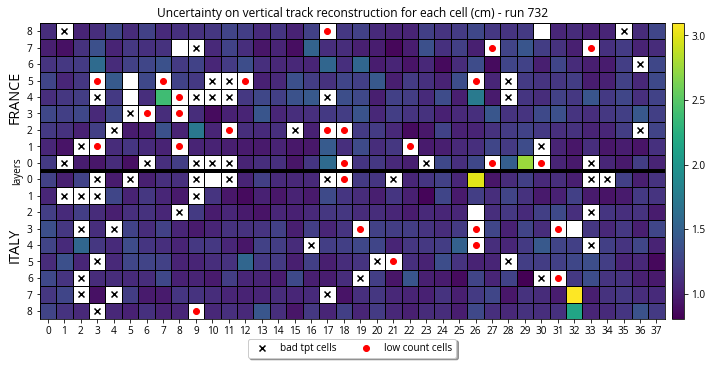

In [314]:
# hist_resids_cell_fromfile(110)
# residual_error_forallcells()
hist2D_cells_resids(bad_cell_list)

# resids = np.loadtxt(residdir+'residuals_cell_0.txt')
# get_sigma(resids, plot_or_not=True)

ATTEMPT AT 2D LINEAR REGRESSION IN (ROW, LAYER) SPACE

In [ ]:
def fn(x, a, b, c):
    return a*x[0] + b*x[1] + c

def test():

    event_number, side = 51, 1
    cell_nums, layers, rows, top_times, bot_times = filter_track(event_number, side)
        
    vert_dist = np.array(vertical_dist(top_times, bot_times))
    # horz_sorted = layers_to_distances(l)

    x = np.array([layers, rows])
    z = vert_dist

    popt_1d, pcov_1d = curve_fit(linear, np.array(layers), z)
    # print(popt_1d)
    residuals_1d = z - linear(np.array(layers), *popt_1d)
    print(residuals_1d)

    popt_2d, pcov_2d = curve_fit(fn, x, z) # 2D linear regression
    # print(popt_2d)
    residuals_2d = z - fn(x, *popt_2d)
    print(residuals_2d)

    print(np.sum(residuals_1d**2))
    print(np.sum(residuals_2d**2))


test()